In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

import numpy as np
from multiprocess import Pool

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

%matplotlib inline

ENABLE_UPLOAD_S3 is not set, default to False.
ENABLE_DOWNLOAD_S3 is not set, default to False.


Setting environment for Precision WorkStation for Alex Newberry
{'UCSD001': 0.325}
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini


Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
stack = 'UCSD001'

atlas_spec = dict(name='atlasV7',
                   vol_type='score'    ,               
                    resolution='10.0um'
                   )

# atlas_spec = dict(name='atlasV6',
#                    vol_type='score'    ,               
#                     resolution='10.0um'
#                    )

In [3]:
atlas_structures_wrt_canonicalAtlasSpace_atlasResol = \
DataManager.load_original_volume_all_known_structures_v3(atlas_spec, in_bbox_wrt='canonicalAtlasSpace',
                                                        out_bbox_wrt='canonicalAtlasSpace')

Prior structure/index map not found. Generating a new one.
File does not exist: /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_volumes/atlasV7/atlasV7_10.0um_scoreVolume/score_volumes/atlasV7_10.0um_scoreVolume_5N_L.bp
[Errno 2] No such file or directory: '/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_volumes/atlasV7/atlasV7_10.0um_scoreVolume/score_volumes/atlasV7_10.0um_scoreVolume_5N_L.bp'
Score volume for 5N_L does not exist.
File does not exist: /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_volumes/atlasV7/atlasV7_10.0um_scoreVolume/score_volumes/atlasV7_10.0um_scoreVolume_5N_R.bp
[Errno 2] No such file or directory: '/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_volumes/atlasV7/atlasV7_10.0um_scoreVolume/score_volumes/atlasV7_10.0um_scoreVolume_5N_R.bp'
Score volume for 5N_R does not exist.
File does not exist: /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_volumes/atlasV7/atlasV7_10.0um_scoreVolume/score_volumes/atlasV7_10.0um_scoreVolume_6N_L.bp
[Errno 2] No s

# Identify 3-d bounding box of each simpleGlobal aligned structure

In [6]:
bp.unpack_ndarray_file(os.path.join(DATA_ROOTDIR, 'CSHL_simple_global_registration', \
                                stack + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp'))

array([[ 9.69648022e-01,  2.44280332e-01,  1.07114495e-02,
         1.16374282e+03],
       [-2.44144886e-01,  9.69660220e-01, -1.25393320e-02,
         5.64443355e+02],
       [-1.34495127e-02,  9.54354611e-03,  9.99864006e-01,
         5.63000000e+02]])

In [7]:
# for stack in all_nissl_stacks:
# for stack in ['MD661']:
for stack in ['UCSD001']:

    T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = \
    bp.unpack_ndarray_file(os.path.join(DATA_ROOTDIR, 'CSHL_simple_global_registration', \
                                stack + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp'))

    registered_atlas_structures_wrt_wholebrain_atlasResol = \
    {name_s: transform_volume_v4(volume=vo,
                                 transform=T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol, 
                                 return_origin_instead_of_bbox=True)
    for name_s, vo in atlas_structures_wrt_canonicalAtlasSpace_atlasResol.iteritems()}

    registered_atlas_structures_bbox_wrt_wholebrain_atlasResol = \
    {name_s: (o[0], o[0] + v.shape[1] - 1, o[1], o[1] + v.shape[0] - 1, o[2], o[2] + v.shape[2] - 1)
    for name_s, (v, o) in registered_atlas_structures_wrt_wholebrain_atlasResol.iteritems()}

    registered_atlas_structures_xyzTwoCorners_wrt_wholebrain_atlasResol = \
    {name_s: ((o[0], o[2], o[4]), (o[1], o[3], o[5]))
    for name_s, o in registered_atlas_structures_bbox_wrt_wholebrain_atlasResol.iteritems()}

#     registered_atlas_structures_xyzCorners_wrt_wholebrainWithMargin_atlasResol = \
#     {name_s: ((o[0], o[2], o[4]), (o[0], o[2], o[5]), (o[0], o[3], o[4]), (o[0], o[3], o[5]), \
#              (o[1], o[2], o[4]), (o[1], o[2], o[5]), (o[1], o[3], o[4]), (o[1], o[3], o[5]))
#     for name_s, o in registered_atlas_structures_bbox_wrt_wholebrainWithMargin_atlasResol.iteritems()}

    
    atlas_resol = atlas_spec['resolution']
    
    from data_manager import CoordinatesConverter

    converter = CoordinatesConverter(stack=stack)

    registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners_raw = {}

    for name_s, corners_xyz in registered_atlas_structures_xyzTwoCorners_wrt_wholebrain_atlasResol.iteritems():
    #     print name_s
        registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners_raw[name_s] = \
        converter.convert_frame_and_resolution(p=corners_xyz, 
                                           in_wrt=('wholebrain', 'sagittal'),
                                          in_resolution=atlas_resol,
                                          out_wrt=('wholebrainXYcropped', 'sagittal'),
                                          out_resolution='raw_raw_section').astype(np.int)

    save_json(registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners_raw, 
          os.path.join(DATA_ROOTDIR, 'CSHL_simple_global_registration', \
                       stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json'))

/home/alexn/brainDev/src/utilities/registration_utilities.py:1571: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(volume_m_aligned_to_f.dtype, np.float):
Interpolating/filling sparse volume: 0.03 seconds.
Interpolating/filling sparse volume: 0.00 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Seems you are using operation INIs to provide cropbox.


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini


## Testing ---

`atlas_structures_wrt_canonicalAtlasSpace_atlasResol` loaded from `STACK_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp` file
    - shape (78, 124, 86)

-> converted to `registered_atlas_structures_wrt_wholebrain_atlasResol`
    - shape (71, 142, 91)
    
-> bounding box is generated from this, `registered_atlas_structures_bbox_wrt_wholebrain_atlasResol`
    - '12N': (1301, 1442, 546, 616, 170, 260)
    - loaded into `corners_xyz`, same data, different format
        - ((1301, 546, 170), (1442, 616, 260))

-> transformed with "converter.convert_frame_and_resolution()" saved to `STACK_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json`
    - 12N: [[16990, 11360, 86],
            [21329, 13513, 131]]
            
-> Rang of sections values are computed for: 
    - lower_bound: max(secmin - section_margin, valid_secmin),
    - upper_bound: min(secmax + 1 + section_margin, valid_secmax)+1
    - (section_margin = int(section_margin_um / SECTION_THICKNESS)) where section_margin_um=400

In [14]:
secmin - section_margin, valid_secmin

NameError: name 'valid_secmin' is not defined

In [194]:
secmax + 1 + section_margin, valid_secmax

(157, 360)

(78, 124, 86)


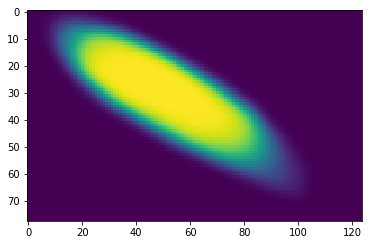

In [195]:
print shape(atlas_structures_wrt_canonicalAtlasSpace_atlasResol['12N'][0])

imshow( atlas_structures_wrt_canonicalAtlasSpace_atlasResol['12N'][0][:,:,70] ) 

['3N_R', '4N_R', '12N']
(69, 140, 87)


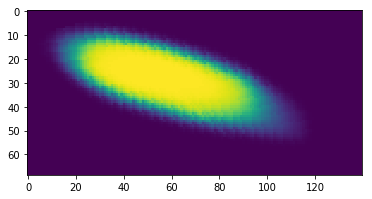

In [196]:
print registered_atlas_structures_wrt_wholebrain_atlasResol.keys()
print shape( registered_atlas_structures_wrt_wholebrain_atlasResol['12N'][0])
imshow( registered_atlas_structures_wrt_wholebrain_atlasResol['12N'][0][:,:,70] ) 

In [197]:
registered_atlas_structures_bbox_wrt_wholebrain_atlasResol

{'12N': (1308, 1447, 548, 616, 516, 602),
 '3N_R': (972, 1041, 466, 520, 551, 603),
 '4N_R': (1029, 1052, 476, 502, 577, 598)}

In [198]:
corners_xyz

((1308, 548, 516), (1447, 616, 602))

In [199]:
registered_atlas_structures_xyzTwoCorners_wrt_wholebrain_atlasResol

{'12N': ((1308, 548, 516), (1447, 616, 602)),
 '3N_R': ((972, 466, 551), (1041, 520, 603)),
 '4N_R': ((1029, 476, 577), (1052, 502, 598))}

In [200]:
registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners

{u'12N': [[16990, 11360, 86], [21329, 13513, 131]],
 u'3N_R': [[6836, 8590, 112], [8960, 10221, 139]],
 u'4N_R': [[8590, 8929, 125], [9329, 9729, 136]]}

In [201]:
registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners_raw

{'12N': array([[17206, 11421,   259],
        [21483, 13513,   302]]), '3N_R': array([[ 6867,  8898,   276],
        [ 8990, 10560,   302]]), '4N_R': array([[ 8621,  9206,   289],
        [ 9329, 10006,   300]])}

## Testing ---

In [202]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

ENABLE_DOWNLOAD_S3 is False. Skip downloading from S3.


In [203]:
# out_resolution_um = 10.
# out_resolution_str = '%.1fum' % out_resolution_um

# detector_id = 15 # For CSHL nissl data. e.g. MD593
# detector_id = 19 # For CSHL nissl data. e.g. MD589, denser window
detector_id = 799 # For UCSD neurotrace data, e.g. CHATM2, CHATM3

# print 'input_version:', detector_settings.loc[detector_id]['input_version']


bg_img_version = 'NtbNormalizedAdaptiveInvertedGammaJpeg'

In [204]:
# detector_setting = {}
# detector_setting['feature_classifier_id'] = 899
# detector_setting['windowing_id'] = 7

detector_setting = detector_settings.loc[detector_id]
clfs = DataManager.load_classifiers(classifier_id=detector_setting['feature_classifier_id'])
win_id = detector_setting['windowing_id']

Setting 899: No classifier found for 5N.
Setting 899: No classifier found for 6N.
Setting 899: No classifier found for 7N.
Setting 899: No classifier found for 7n.
Setting 899: No classifier found for Amb.
Setting 899: No classifier found for LC.
Setting 899: No classifier found for LRt.
Setting 899: No classifier found for Pn.
Setting 899: No classifier found for Tz.
Setting 899: No classifier found for VLL.
Setting 899: No classifier found for RMC.
Setting 899: No classifier found for SNC.
Setting 899: No classifier found for SNR.
Setting 899: No classifier found for Sp5I.
Setting 899: No classifier found for Sp5O.
Setting 899: No classifier found for Sp5C.
Setting 899: No classifier found for PBG.
Setting 899: No classifier found for 10N.
Setting 899: No classifier found for VCA.
Setting 899: No classifier found for VCP.
Setting 899: No classifier found for DC.
Setting 899: No classifier found for AP.
Setting 899: No classifier found for RtTg.
Setting 899: No classifier found for SC

In [215]:
# motor_nuclei = ['Amb', '3N', '4N', '5N', '6N', '7N', '10N', '12N']
# motor_nuclei = ['SNR', '7N', '5N', '7n', 'LRt', 'Sp5C', 'SNC', 'VLL', 'SC', 'IC']
motor_nuclei = ['12N', '3N', '4N']

normalization_scheme = "none"

In [206]:
motor_nuclei = ['3N']

In [213]:
structure = '12N'

(xmin, ymin, secmin), (xmax, ymax, secmax) = \
                registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[structure]
    
print secmin
print secmax

86
131


In [19]:
print max(secmin - section_margin, valid_secmin)
print min(secmax + 1 + section_margin, valid_secmax)+1

239
324


In [18]:
section_margin_um = 400.
section_margin = int(section_margin_um / SECTION_THICKNESS)
valid_secmin = np.min(metadata_cache['valid_sections'][stack])
valid_secmax = np.max(metadata_cache['valid_sections'][stack])

In [216]:
# for stack in ['CHATM2', 'CHATM3']:
# for stack in all_nissl_stacks:
# for stack in ['MD661']:
# for stack in ['DEMO998']:
for stack in ['UCSD001']:
    
    output_resolution = '10.0um'
    out_resolution_um = convert_resolution_string_to_um(resolution=output_resolution, stack=stack)
    
    valid_secmin = np.min(metadata_cache['valid_sections'][stack])
    valid_secmax = np.max(metadata_cache['valid_sections'][stack])
    print "valid Minimum section: "+str(valid_secmin)
    print "valid Maximum section: "+str(valid_secmax)
    
    ######## Do not use ROI ######

#     raw_w, raw_h = metadata_cache['image_shape'][stack]
    
#     registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection = defaultdict(dict)
    
#     for name_u in motor_nuclei:
#         for sec in range(valid_secmin, valid_secmax+1):  
#             if is_invalid(sec=sec, stack=stack):
#                 continue
            
#             registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = \
#(0,raw_w-1,0,raw_h-1)

    ######## Identify ROI based on simple global alignment ########

    registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = \
load_json(os.path.join(DATA_ROOTDIR, 'CSHL_simple_global_registration', \
                       stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json'))

    registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection = defaultdict(dict)

#     section_margin_um = 1000.
    section_margin_um = 400.
    section_margin = int(section_margin_um / SECTION_THICKNESS)
    
    image_margin_um = 2000.
    image_margin = int(np.round(image_margin_um / convert_resolution_string_to_um('raw', stack)))

#     for name_u in all_known_structures:
    for name_u in motor_nuclei:
        # singular_structures == ['AP', '12N', 'RtTg', 'SC', 'IC']
        if name_u in singular_structures:

            (xmin, ymin, secmin), (xmax, ymax, secmax) = \
            registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[name_u]
            
            print 'Singular Structure: '+name_u
            print '(xmin, ymin, secmin), (xmax, ymax, secmax)'
            print registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[name_u]

            for sec in range(max(secmin - section_margin, valid_secmin), \
                             min(secmax + 1 + section_margin, valid_secmax)+1):
                
                if is_invalid(sec=sec, stack=stack):
                    print 'INVALID'
                    continue

                registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = \
                (max(xmin - image_margin, 0), 
                 xmax + image_margin, 
                 max(ymin - image_margin, 0), 
                 ymax + image_margin)
#                 print 'registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection'
#                 print registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec]
        # If structure exists on right and left hemispheres
        else:

            a = defaultdict(list)

            lname = convert_to_left_name(name_u)        
            
            if lname in registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners:

                (xmin, ymin, secmin), (xmax, ymax, secmax) = \
                registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[lname]
                
#                 print 'Twin Structures: '+name_u
#                 print '(xmin, ymin, secmin), (xmax, ymax, secmax)'

                for sec in range(max(secmin - section_margin, valid_secmin), \
                                 min(secmax + 1 + section_margin, valid_secmax)+1):

                    if is_invalid(sec=sec, stack=stack):
                        continue

                    a[sec].append((max(xmin - image_margin, 0), 
                     xmax + image_margin, 
                     max(ymin - image_margin, 0), 
                     ymax + image_margin))

            rname = convert_to_right_name(name_u)
            
            if rname in registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners:

                (xmin, ymin, secmin), (xmax, ymax, secmax) = \
                registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[rname]

                for sec in range(max(secmin - section_margin, valid_secmin), \
                                 min(secmax + 1 + section_margin, valid_secmax)+1):

                    if is_invalid(sec=sec, stack=stack):
                        continue

                    a[sec].append((max(xmin - image_margin, 0), 
                     xmax + image_margin, 
                     max(ymin - image_margin, 0), 
                     ymax + image_margin))

            for sec, bboxes in a.iteritems():
                if len(bboxes) == 1:
                    registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = \
                    bboxes[0]
                else:
                    xmin, ymin = np.min(bboxes, axis=0)[[0,2]]
                    xmax, ymax = np.max(bboxes, axis=0)[[1,3]]
                    registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection[name_u][sec] = \
                    (xmin, xmax, ymin, ymax)
                    
    ######### Generate score maps ###########
                    
#     for name_u in all_known_structures:
    for name_u in motor_nuclei:
            
        for sec, bbox in sorted(registered_atlas_structures_wrt_wholebrainXYcropped_bboxes_perSection\
                                [name_u].items()):
            
    #         if is_invalid(sec=sec, stack=stack):
    #             continue
        
            print name_u, sec
        
            try:
                
                ############# Generate both scoremap and viz #################
                
                viz_all_landmarks, scoremap_all_landmarks = \
                draw_scoremap(clfs={name_u: clfs[name_u]}, 
                                      bbox=bbox,
                                scheme=normalization_scheme, 
                            win_id=win_id, prep_id=2,
                            stack=stack, 
                              return_what='both',
                              sec=sec,
                            model=model, model_name=model_name,
                             mean_img=mean_img, 
                             batch_size=batch_size,
                              output_patch_size=224,
                              is_nissl=False,
                           out_resolution_um=out_resolution_um,
                                            bg_img_version=bg_img_version,
                        image_shape=metadata_cache['image_shape'][stack],
                                      return_wholeimage=True)
                

                sm = scoremap_all_landmarks[name_u]
                viz = viz_all_landmarks[name_u]

                t = time.time()
                scoremap_bp_filepath = \
                DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                             structure=name_u,
                                                             detector_id=detector_id,
                                                             out_resolution_um=out_resolution_um)
                save_data(sm.astype(np.float16), scoremap_bp_filepath, upload_s3=False)
                sys.stderr.write('Save scoremap: %.2f seconds\n' % (time.time() - t))

                t = time.time()
                viz_filepath = \
                DataManager.get_scoremap_viz_filepath_v2(stack=stack, section=sec, 
                                                             structure=name_u,
                                                             detector_id=detector_id,
                                                             out_resolution=output_resolution)
                save_data(viz, viz_filepath, upload_s3=False)
                sys.stderr.write('Save scoremap viz: %.2f seconds\n' % (time.time() - t))
                
                del viz_all_landmarks, scoremap_all_landmarks
                
                ################ Generate scoremap only ################
        
#                 scoremap_all_landmarks = \
#                 draw_scoremap(clfs={name_u: clfs[name_u]}, 
#                                       bbox=bbox,
#                                 scheme='none', 
#                             win_id=win_id, prep_id=2,
#                             stack=stack, 
#                               return_what='scoremap',
#                               sec=sec,
#                             model=model, model_name=model_name,
#                              mean_img=mean_img, 
#                              batch_size=batch_size,
#                               output_patch_size=224,
#                               is_nissl=False,
#                            out_resolution_um=out_resolution_um,
#                         image_shape=metadata_cache['image_shape'][stack],
#                                       return_wholeimage=True)

#                 sm = scoremap_all_landmarks[name_u]

#                 scoremap_bp_filepath = \
#                 DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
#                                                              structure=name_u,
#                                                              detector_id=detector_id,
#                                                              out_resolution_um=out_resolution_um)
#                 save_data(sm.astype(np.float16), scoremap_bp_filepath, upload_s3=False)

#                 del scoremap_all_landmarks
        
            except Exception as e:
                sys.stderr.write('************************************************************************\n')
                sys.stderr.write('!!!!!!!!!!! Scoremap generation FAILED: %s\n' % e)
                continue

        
    ######### Generate score volumes ##########
        
# #     for name_u in all_known_structures:
#     for name_u in motor_nuclei:

        for name_s in [convert_to_left_name(name_u), convert_to_right_name(name_u)]:

            scoremaps = {}

    #         for sec in metadata_cache['valid_sections'][stack]:

            if name_s not in registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners:
                sys.stderr.write("Score volume ROI derived from simple global alignment does not exist. \
                Skip generating score volume.\n")
                continue
          
            (xmin, ymin, s1), (xmax, ymax, s2) = \
            registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[name_s]

            for sec in range(max(s1 - section_margin, metadata_cache['section_limits'][stack][0]), 
                             min(s2 + 1 + section_margin, metadata_cache['section_limits'][stack][1])+1):

                if is_invalid(sec=sec, stack=stack):
                    continue
                
                try:
                    scoremap = DataManager.load_downscaled_scoremap(stack=stack, section=sec, structure=name_u, 
                                                                    prep_id='alignedBrainstemCrop',
                                                                  out_resolution_um=out_resolution_um, 
                                                                    detector_id=detector_id).astype(np.float32)
                except Exception as e:
                    sys.stderr.write('%s\n' % e)
                    continue
                    
                mask = DataManager.load_image_v2(stack=stack, section=sec, 
                                     prep_id='alignedBrainstemCrop', 
                                     resol='thumbnail', version='mask')

                mask_outResol = rescale_by_resampling(mask, new_shape=(scoremap.shape[1], scoremap.shape[0]))

                scoremap[~mask_outResol] = 0
                scoremaps[sec] = scoremap
                
            t = time.time()

            volume_outVolResol, volume_origin_wrt_wholebrainXYcropped_outVolResol = \
            images_to_volume_v2(images=scoremaps, spacing_um=20.,
                                    in_resol_um=out_resolution_um,
                                    out_resol_um=out_resolution_um)

            sys.stderr.write('Images to volume: %.2f seconds\n' % (time.time() - t))

            brain_spec = dict(name=stack,
                           vol_type='score',
                            detector_id=detector_id,
                           resolution=output_resolution)

            # Save volume and origin.

            t = time.time()
            save_data(volume_outVolResol.astype(np.float16), \
                      DataManager.get_original_volume_filepath_v2(stack_spec=brain_spec, structure=name_s))

            wholebrainXYcropped_origin_wrt_wholebrain_outVolResol = \
            DataManager.get_domain_origin(stack=stack, domain='wholebrainXYcropped', 
                                          resolution=output_resolution)
            volume_origin_wrt_wholebrain_outVolResol =\
            volume_origin_wrt_wholebrainXYcropped_outVolResol + \
            wholebrainXYcropped_origin_wrt_wholebrain_outVolResol

            save_data(volume_origin_wrt_wholebrain_outVolResol,
                      DataManager.get_original_volume_origin_filepath_v3(stack_spec=brain_spec, \
                                                                         structure=name_s, wrt='wholebrain'))

            sys.stderr.write('Save score volume: %.2f seconds\n' % (time.time() - t))
            
            # Compute gradients.

            t = time.time()
            gradients = compute_gradient_v2((volume_outVolResol, volume_origin_wrt_wholebrain_outVolResol), 
                                            smooth_first=True)
            sys.stderr.write('Compute gradient: %.2f seconds\n' % (time.time() - t))

            t = time.time()
            DataManager.save_volume_gradients(gradients, stack_spec=brain_spec, structure=name_s)
            sys.stderr.write('Save gradient: %.2f seconds\n' % (time.time() - t))

valid Minimum section: 105
valid Maximum section: 360
Singular Structure: 12N
(xmin, ymin, secmin), (xmax, ymax, secmax)
[[17206, 11421, 259], [21483, 13513, 302]]
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
INVALID
12N 239


Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide059_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.36 seconds


['UCSD001', 239, 'UCSD001_slide059_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide059_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide059_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
18082 ROI sampled locations
18414 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 74 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide059_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide059_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.41 seconds.
Rescale image from 317 to 224: 5.38 seconds.
Crop patches: 0.38 seconds.
Extract patches: 20.19 seconds


(18082, 1, 224, 224)


Compute features: 26.81 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide059_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide059_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 0.94 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide059_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.04 seconds
Rescale background image to output resolution: 10.27 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.
Generate scoremap overlay image 12N: 0.22 seconds


(719, 1103, 3) (719, 1103)
12N 240


Save scoremap: 0.03 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide060_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 240, 'UCSD001_slide060_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide060_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide060_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
21163 ROI sampled locations
21523 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 45 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide060_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide060_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.53 seconds.
Rescale image from 317 to 224: 5.46 seconds.
Crop patches: 0.44 seconds.
Extract patches: 20.45 seconds


(21163, 1, 224, 224)


Compute features: 32.53 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide060_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide060_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide060_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 11.82 seconds
Predict scores 12N: 0.16 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
12N 241
['UCSD001', 241, 'UCSD001_slide061_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 66 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.71 seconds.
Rescale image from 317 to 224: 5.50 seconds.
Crop patches: 0.44 seconds.
Extract patches: 20.67 seconds


21229 ROI sampled locations
21563 pre-computed locations
(21229, 1, 224, 224)


Compute features: 32.22 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.05 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide061_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 11.54 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
12N 242
['UCSD001', 242, 'UCSD001_slide062_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.21 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide062_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
20699 ROI sampled locations
21050 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 55 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide062_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide062_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.86 seconds.
Rescale image from 317 to 224: 5.55 seconds.
Crop patches: 0.43 seconds.
Extract patches: 20.86 seconds


(20699, 1, 224, 224)


Compute features: 31.76 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.04 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide062_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.38 seconds
Rescale background image to output resolution: 10.34 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
12N 243
['UCSD001', 243, 'UCSD001_slide061_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
21549 ROI sampled locations
21885 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 68 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 13.70 seconds.
Rescale image from 317 to 224: 5.61 seconds.
Crop patches: 0.45 seconds.
Extract patches: 19.79 seconds


(21549, 1, 224, 224)


Compute features: 33.69 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.04 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide061_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.08 seconds
Rescale background image to output resolution: 10.42 seconds
Predict scores 12N: 0.16 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
12N 244


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide062_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 244, 'UCSD001_slide062_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 73 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide062_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide062_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.92 seconds.
Rescale image from 317 to 224: 5.48 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.00 seconds


21350 ROI sampled locations
21671 pre-computed locations
(21350, 1, 224, 224)


Compute features: 32.83 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide062_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.32 seconds
Rescale background image to output resolution: 9.76 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 12N: 0.28 seconds


(719, 1103, 3) (719, 1103)
12N 245


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.06 seconds


['UCSD001', 245, 'UCSD001_slide061_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
20796 ROI sampled locations
21122 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 74 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.70 seconds.
Rescale image from 317 to 224: 5.39 seconds.
Crop patches: 0.57 seconds.
Extract patches: 20.68 seconds


(20796, 1, 224, 224)


Compute features: 32.63 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide061_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.35 seconds
Rescale background image to output resolution: 9.98 seconds
Predict scores 12N: 0.19 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 246


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide062_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


['UCSD001', 246, 'UCSD001_slide062_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
20740 ROI sampled locations
21062 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 70 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide062_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide062_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.04 seconds.
Rescale image from 317 to 224: 6.27 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.87 seconds


(20740, 1, 224, 224)


Compute features: 31.89 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide062_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide062_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.32 seconds
Rescale background image to output resolution: 9.48 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 247
['UCSD001', 247, 'UCSD001_slide061_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
21371 ROI sampled locations
21700 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 73 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide061_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.01 seconds.
Rescale image from 317 to 224: 5.40 seconds.
Crop patches: 0.52 seconds.
Extract patches: 20.94 seconds


(21371, 1, 224, 224)


Compute features: 32.78 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide061_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.22 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide061_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.30 seconds
Rescale background image to output resolution: 10.32 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 249
['UCSD001', 249, 'UCSD001_slide063_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide063_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
21104 ROI sampled locations
21429 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 71 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.15 seconds.
Rescale image from 317 to 224: 5.17 seconds.
Crop patches: 0.49 seconds.
Extract patches: 20.82 seconds


(21104, 1, 224, 224)


Compute features: 32.07 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.38 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide063_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.30 seconds
Rescale background image to output resolution: 9.81 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 250


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide064_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.06 seconds


['UCSD001', 250, 'UCSD001_slide064_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
21070 ROI sampled locations
21425 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 46 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.04 seconds.
Rescale image from 317 to 224: 5.82 seconds.
Crop patches: 0.50 seconds.
Extract patches: 21.37 seconds


(21070, 1, 224, 224)


Compute features: 32.49 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide064_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.46 seconds
Rescale background image to output resolution: 9.91 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 251
['UCSD001', 251, 'UCSD001_slide063_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide063_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
21472 ROI sampled locations
21804 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 72 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.66 seconds.
Rescale image from 317 to 224: 5.37 seconds.
Crop patches: 0.52 seconds.
Extract patches: 20.57 seconds


(21472, 1, 224, 224)


Compute features: 33.08 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.24 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide063_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.60 seconds
Rescale background image to output resolution: 10.37 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide064_2018_09_04-S2_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 252


locate patches: 0.05 seconds


['UCSD001', 252, 'UCSD001_slide064_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
20783 ROI sampled locations
21109 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 67 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.18 seconds.
Rescale image from 317 to 224: 5.38 seconds.
Crop patches: 0.48 seconds.
Extract patches: 21.05 seconds


(20783, 1, 224, 224)


Compute features: 31.77 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.22 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide064_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.21 seconds
Rescale background image to output resolution: 9.45 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 253


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide063_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 253, 'UCSD001_slide063_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
21642 ROI sampled locations
21975 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 73 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.24 seconds.
Rescale image from 317 to 224: 5.90 seconds.
Crop patches: 0.52 seconds.
Extract patches: 21.67 seconds


(21642, 1, 224, 224)


Compute features: 33.13 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.26 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide063_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.14 seconds
Rescale background image to output resolution: 9.51 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 254


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide064_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 254, 'UCSD001_slide064_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
21619 ROI sampled locations
21951 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 72 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.46 seconds.
Rescale image from 317 to 224: 5.68 seconds.
Crop patches: 0.51 seconds.
Extract patches: 21.66 seconds


(21619, 1, 224, 224)


Compute features: 33.45 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide064_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.50 seconds
Rescale background image to output resolution: 10.52 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide063_2018_09_04-S4_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 255
['UCSD001', 255, 'UCSD001_slide063_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 64 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide063_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.28 seconds.
Rescale image from 317 to 224: 6.23 seconds.
Crop patches: 0.47 seconds.
Extract patches: 21.00 seconds


18234 ROI sampled locations
18516 pre-computed locations
(18234, 1, 224, 224)


Compute features: 27.53 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide063_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide063_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.96 seconds
Rescale background image to output resolution: 9.89 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 256


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide064_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.22 seconds


['UCSD001', 256, 'UCSD001_slide064_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
22536 ROI sampled locations
22874 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 75 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.81 seconds.
Rescale image from 317 to 224: 5.39 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.76 seconds


(22536, 1, 224, 224)


Compute features: 34.53 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.27 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide064_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.82 seconds
Rescale background image to output resolution: 9.78 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 257


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 257, 'UCSD001_slide065_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
22702 ROI sampled locations
23058 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 77 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.36 seconds.
Rescale image from 317 to 224: 5.79 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.71 seconds


(22702, 1, 224, 224)


Compute features: 34.97 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.59 seconds
Rescale background image to output resolution: 9.33 seconds
Predict scores 12N: 0.14 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 258


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


['UCSD001', 258, 'UCSD001_slide066_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23496 ROI sampled locations
23835 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 76 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 16.07 seconds.
Rescale image from 317 to 224: 6.23 seconds.
Crop patches: 0.59 seconds.
Extract patches: 22.90 seconds


(23496, 1, 224, 224)


Compute features: 35.65 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.43 seconds
Rescale background image to output resolution: 8.48 seconds
Predict scores 12N: 0.15 seconds
Resample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 259


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 259, 'UCSD001_slide065_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
21593 ROI sampled locations
21929 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 72 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.91 seconds.
Rescale image from 317 to 224: 5.23 seconds.
Crop patches: 0.53 seconds.
Extract patches: 20.69 seconds


(21593, 1, 224, 224)


Compute features: 33.25 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.12 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.18 seconds
Rescale background image to output resolution: 8.50 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 260
['UCSD001', 260, 'UCSD001_slide066_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
22293 ROI sampled locations
22631 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 73 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.09 seconds.
Rescale image from 317 to 224: 6.23 seconds.
Crop patches: 0.55 seconds.
Extract patches: 21.89 seconds


(22293, 1, 224, 224)


Compute features: 34.64 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.42 seconds
Rescale background image to output resolution: 9.51 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 261


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 261, 'UCSD001_slide065_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
22483 ROI sampled locations
22822 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 73 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 16.06 seconds.
Rescale image from 317 to 224: 5.85 seconds.
Crop patches: 0.54 seconds.
Extract patches: 22.48 seconds


(22483, 1, 224, 224)


Compute features: 34.71 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.57 seconds
Rescale background image to output resolution: 9.61 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 262
['UCSD001', 262, 'UCSD001_slide066_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
22496 ROI sampled locations
22831 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 76 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.42 seconds.
Rescale image from 317 to 224: 5.41 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.38 seconds


(22496, 1, 224, 224)


Compute features: 34.22 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.27 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.31 seconds
Rescale background image to output resolution: 9.53 seconds
Predict scores 12N: 0.14 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 263


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 263, 'UCSD001_slide065_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
22393 ROI sampled locations
22752 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 51 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.52 seconds.
Rescale image from 317 to 224: 5.61 seconds.
Crop patches: 0.52 seconds.
Extract patches: 21.66 seconds


(22393, 1, 224, 224)


Compute features: 35.17 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.34 seconds
Rescale background image to output resolution: 9.91 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 264


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 264, 'UCSD001_slide066_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
22524 ROI sampled locations
22860 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 73 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.07 seconds.
Rescale image from 317 to 224: 5.59 seconds.
Crop patches: 0.52 seconds.
Extract patches: 21.20 seconds


(22524, 1, 224, 224)


Compute features: 33.97 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.15 seconds
Rescale background image to output resolution: 9.53 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 265


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 265, 'UCSD001_slide067_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
22344 ROI sampled locations
22681 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 72 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.80 seconds.
Rescale image from 317 to 224: 5.87 seconds.
Crop patches: 0.54 seconds.
Extract patches: 22.23 seconds


(22344, 1, 224, 224)


Compute features: 34.10 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.42 seconds
Rescale background image to output resolution: 8.57 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 266


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 266, 'UCSD001_slide068_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 74 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.54 seconds.
Rescale image from 317 to 224: 6.07 seconds.
Crop patches: 0.57 seconds.
Extract patches: 22.20 seconds


22530 ROI sampled locations
22866 pre-computed locations
(22530, 1, 224, 224)


Compute features: 34.43 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.36 seconds
Rescale background image to output resolution: 9.18 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 267


Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 267, 'UCSD001_slide067_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
22459 ROI sampled locations
22793 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 74 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.14 seconds.
Rescale image from 317 to 224: 5.46 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.15 seconds


(22459, 1, 224, 224)


Compute features: 34.55 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 9.49 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 268


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 268, 'UCSD001_slide068_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
22465 ROI sampled locations
22801 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 72 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.60 seconds.
Rescale image from 317 to 224: 6.23 seconds.
Crop patches: 0.56 seconds.
Extract patches: 22.41 seconds


(22465, 1, 224, 224)


Compute features: 34.12 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.26 seconds
Rescale background image to output resolution: 8.37 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 269


locate patches: 0.05 seconds


['UCSD001', 269, 'UCSD001_slide067_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
22576 ROI sampled locations
22914 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 72 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.17 seconds.
Rescale image from 317 to 224: 5.37 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.09 seconds


(22576, 1, 224, 224)


Compute features: 34.61 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.01 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.90 seconds
Rescale background image to output resolution: 9.49 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 270


locate patches: 0.09 seconds


['UCSD001', 270, 'UCSD001_slide068_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
22342 ROI sampled locations
22679 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 71 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.28 seconds.
Rescale image from 317 to 224: 5.59 seconds.
Crop patches: 0.52 seconds.
Extract patches: 21.40 seconds


(22342, 1, 224, 224)


Compute features: 34.63 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.34 seconds
Rescale background image to output resolution: 9.83 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 271


Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


['UCSD001', 271, 'UCSD001_slide067_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
22518 ROI sampled locations
22855 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 72 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.45 seconds.
Rescale image from 317 to 224: 5.80 seconds.
Crop patches: 0.55 seconds.
Extract patches: 21.82 seconds


(22518, 1, 224, 224)


Compute features: 34.81 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.29 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.27 seconds
Rescale background image to output resolution: 9.53 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 272
['UCSD001', 272, 'UCSD001_slide068_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
22078 ROI sampled locations
22419 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 67 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.42 seconds.
Rescale image from 317 to 224: 5.46 seconds.
Crop patches: 0.52 seconds.
Extract patches: 21.42 seconds


(22078, 1, 224, 224)


Compute features: 34.37 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.20 seconds
Rescale background image to output resolution: 9.48 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S1_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 273


locate patches: 0.04 seconds


['UCSD001', 273, 'UCSD001_slide069_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23032 ROI sampled locations
23375 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 69 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.57 seconds.
Rescale image from 317 to 224: 5.56 seconds.
Crop patches: 0.55 seconds.
Extract patches: 21.70 seconds


(23032, 1, 224, 224)


Compute features: 34.88 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.37 seconds
Rescale background image to output resolution: 8.51 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 274


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 274, 'UCSD001_slide070_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
22221 ROI sampled locations
22561 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 70 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.65 seconds.
Rescale image from 317 to 224: 5.68 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.89 seconds


(22221, 1, 224, 224)


Compute features: 34.99 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.43 seconds
Rescale background image to output resolution: 9.55 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S2_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 275


locate patches: 0.06 seconds


['UCSD001', 275, 'UCSD001_slide069_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
22280 ROI sampled locations
22619 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 69 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.01 seconds.
Rescale image from 317 to 224: 5.14 seconds.
Crop patches: 0.51 seconds.
Extract patches: 20.67 seconds


(22280, 1, 224, 224)


Compute features: 33.89 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 8.42 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 276


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 276, 'UCSD001_slide070_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
15998 ROI sampled locations
16312 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 13.87 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.37 seconds.
Extract patches: 19.60 seconds


(15998, 1, 224, 224)


Compute features: 24.38 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 0.93 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.09 seconds
Rescale background image to output resolution: 10.25 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 277
['UCSD001', 277, 'UCSD001_slide069_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
22228 ROI sampled locations
22569 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 69 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.44 seconds.
Rescale image from 317 to 224: 5.79 seconds.
Crop patches: 0.53 seconds.
Extract patches: 21.77 seconds


(22228, 1, 224, 224)


Compute features: 34.17 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.40 seconds
Rescale background image to output resolution: 8.48 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 278


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.15 seconds


['UCSD001', 278, 'UCSD001_slide070_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 70 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.53 seconds.
Rescale image from 317 to 224: 5.35 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.44 seconds


22228 ROI sampled locations
22569 pre-computed locations
(22228, 1, 224, 224)


Compute features: 33.67 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.29 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.40 seconds
Rescale background image to output resolution: 8.70 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 279
['UCSD001', 279, 'UCSD001_slide069_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 70 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.59 seconds.
Rescale image from 317 to 224: 6.21 seconds.
Crop patches: 0.57 seconds.
Extract patches: 22.39 seconds


22304 ROI sampled locations
22640 pre-computed locations
(22304, 1, 224, 224)


Compute features: 34.31 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.64 seconds
Rescale background image to output resolution: 10.12 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 280


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 280, 'UCSD001_slide070_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 67 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.27 seconds.
Rescale image from 317 to 224: 5.33 seconds.
Crop patches: 0.52 seconds.
Extract patches: 21.14 seconds


22133 ROI sampled locations
22473 pre-computed locations
(22133, 1, 224, 224)


Compute features: 33.59 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.52 seconds
Rescale background image to output resolution: 9.91 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide071_2018_09_04-S1_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 281


locate patches: 0.05 seconds


['UCSD001', 281, 'UCSD001_slide071_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
22212 ROI sampled locations
22550 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 69 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.67 seconds.
Rescale image from 317 to 224: 5.79 seconds.
Crop patches: 0.52 seconds.
Extract patches: 22.00 seconds


(22212, 1, 224, 224)


Compute features: 33.75 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.26 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide071_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.71 seconds
Rescale background image to output resolution: 9.88 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide072_2018_09_04-S2_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 284


locate patches: 0.05 seconds


['UCSD001', 284, 'UCSD001_slide072_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
21691 ROI sampled locations
22031 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 63 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.36 seconds.
Rescale image from 317 to 224: 6.16 seconds.
Crop patches: 0.55 seconds.
Extract patches: 22.09 seconds


(21691, 1, 224, 224)


Compute features: 33.17 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide072_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.59 seconds
Rescale background image to output resolution: 9.78 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 285


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide071_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 285, 'UCSD001_slide071_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
21801 ROI sampled locations
22140 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 63 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.86 seconds.
Rescale image from 317 to 224: 5.42 seconds.
Crop patches: 0.52 seconds.
Extract patches: 21.81 seconds


(21801, 1, 224, 224)


Compute features: 33.34 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.26 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide071_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.57 seconds
Rescale background image to output resolution: 10.17 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
12N 286


Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide072_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


['UCSD001', 286, 'UCSD001_slide072_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
21756 ROI sampled locations
22096 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 63 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.42 seconds.
Rescale image from 317 to 224: 5.51 seconds.
Crop patches: 0.51 seconds.
Extract patches: 21.45 seconds


(21756, 1, 224, 224)


Compute features: 32.98 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.14 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide072_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.43 seconds
Rescale background image to output resolution: 9.55 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide071_2018_09_04-S4_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 287
['UCSD001', 287, 'UCSD001_slide071_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
21771 ROI sampled locations
22110 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 62 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.70 seconds.
Rescale image from 317 to 224: 5.94 seconds.
Crop patches: 0.54 seconds.
Extract patches: 22.20 seconds


(21771, 1, 224, 224)


Compute features: 32.96 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.27 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide071_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.54 seconds
Rescale background image to output resolution: 8.84 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 288


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide072_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.17 seconds


['UCSD001', 288, 'UCSD001_slide072_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
21609 ROI sampled locations
21951 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 61 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.28 seconds.
Rescale image from 317 to 224: 6.45 seconds.
Crop patches: 0.54 seconds.
Extract patches: 22.29 seconds


(21609, 1, 224, 224)


Compute features: 32.58 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.27 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide072_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.55 seconds
Rescale background image to output resolution: 9.85 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds


(719, 1103, 3) (719, 1103)
12N 289


Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 289, 'UCSD001_slide073_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
21486 ROI sampled locations
21829 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 60 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.75 seconds.
Rescale image from 317 to 224: 5.73 seconds.
Crop patches: 0.51 seconds.
Extract patches: 22.01 seconds


(21486, 1, 224, 224)


Compute features: 32.44 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.26 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.61 seconds
Rescale background image to output resolution: 9.99 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 290


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.20 seconds


['UCSD001', 290, 'UCSD001_slide074_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
21785 ROI sampled locations
22124 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 61 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 16.55 seconds.
Rescale image from 317 to 224: 6.39 seconds.
Crop patches: 0.53 seconds.
Extract patches: 23.49 seconds


(21785, 1, 224, 224)


Compute features: 33.15 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.22 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.46 seconds
Rescale background image to output resolution: 9.65 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 291


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 291, 'UCSD001_slide073_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
21388 ROI sampled locations
21731 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 57 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.64 seconds.
Rescale image from 317 to 224: 5.69 seconds.
Crop patches: 0.49 seconds.
Extract patches: 21.84 seconds


(21388, 1, 224, 224)


Compute features: 33.02 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.46 seconds
Rescale background image to output resolution: 9.65 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 292


Generate scoremap overlay image 12N: 0.23 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 292, 'UCSD001_slide074_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
21313 ROI sampled locations
21656 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 57 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.67 seconds.
Rescale image from 317 to 224: 5.67 seconds.
Crop patches: 0.49 seconds.
Extract patches: 21.85 seconds


(21313, 1, 224, 224)


Compute features: 33.01 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.29 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.40 seconds
Rescale background image to output resolution: 9.62 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 293


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 293, 'UCSD001_slide073_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
21239 ROI sampled locations
21583 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 55 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.67 seconds.
Rescale image from 317 to 224: 5.44 seconds.
Crop patches: 0.50 seconds.
Extract patches: 21.63 seconds


(21239, 1, 224, 224)


Compute features: 32.20 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.26 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.49 seconds
Rescale background image to output resolution: 8.60 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 294


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 294, 'UCSD001_slide074_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
21310 ROI sampled locations
21657 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 53 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.56 seconds.
Rescale image from 317 to 224: 6.31 seconds.
Crop patches: 0.53 seconds.
Extract patches: 22.42 seconds


(21310, 1, 224, 224)


Compute features: 33.24 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.25 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.28 seconds
Rescale background image to output resolution: 9.57 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 295


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


['UCSD001', 295, 'UCSD001_slide073_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
21147 ROI sampled locations
21495 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 52 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.91 seconds.
Rescale image from 317 to 224: 6.30 seconds.
Crop patches: 0.53 seconds.
Extract patches: 22.76 seconds


(21147, 1, 224, 224)


Compute features: 32.17 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.24 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.60 seconds
Rescale background image to output resolution: 8.80 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 296


Generate scoremap overlay image 12N: 0.23 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.07 seconds


['UCSD001', 296, 'UCSD001_slide074_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 50 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.92 seconds.
Rescale image from 317 to 224: 5.20 seconds.
Crop patches: 0.48 seconds.
Extract patches: 21.62 seconds


21041 ROI sampled locations
21391 pre-computed locations
(21041, 1, 224, 224)


Compute features: 32.26 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.24 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.63 seconds
Rescale background image to output resolution: 10.19 seconds
Predict scores 12N: 0.13 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 297


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


['UCSD001', 297, 'UCSD001_slide075_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
20395 ROI sampled locations
20795 pre-computed locations


Load pre-computed features: 2.79 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.33 seconds
Rescale background image to output resolution: 9.38 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 298


Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 298, 'UCSD001_slide076_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
20675 ROI sampled locations
21031 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 44 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.95 seconds.
Rescale image from 317 to 224: 6.25 seconds.
Crop patches: 0.52 seconds.
Extract patches: 22.74 seconds


(20675, 1, 224, 224)


Compute features: 30.99 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.22 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.38 seconds
Rescale background image to output resolution: 9.38 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 299


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.06 seconds


['UCSD001', 299, 'UCSD001_slide075_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
20647 ROI sampled locations
21002 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 43 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.28 seconds.
Rescale image from 317 to 224: 5.82 seconds.
Crop patches: 0.49 seconds.
Extract patches: 21.60 seconds


(20647, 1, 224, 224)


Compute features: 32.10 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.22 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.47 seconds
Rescale background image to output resolution: 9.73 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 300
['UCSD001', 300, 'UCSD001_slide076_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
20511 ROI sampled locations
20870 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 38 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.34 seconds.
Rescale image from 317 to 224: 6.25 seconds.
Crop patches: 0.51 seconds.
Extract patches: 22.12 seconds


(20511, 1, 224, 224)


Compute features: 31.21 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.22 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 9.50 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 301
['UCSD001', 301, 'UCSD001_slide075_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 26 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.35 seconds.
Rescale image from 317 to 224: 6.23 seconds.
Crop patches: 0.50 seconds.
Extract patches: 22.09 seconds


20052 ROI sampled locations
20424 pre-computed locations
(20052, 1, 224, 224)


Compute features: 30.92 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.17 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.16 seconds
Rescale background image to output resolution: 9.47 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


(719, 1103, 3) (719, 1103)
12N 302
['UCSD001', 302, 'UCSD001_slide075_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
20196 ROI sampled locations
20557 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 35 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.21 seconds.
Rescale image from 317 to 224: 5.58 seconds.
Crop patches: 0.46 seconds.
Extract patches: 21.27 seconds


(20196, 1, 224, 224)


Compute features: 30.37 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.13 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.47 seconds
Rescale background image to output resolution: 9.78 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 303
['UCSD001', 303, 'UCSD001_slide076_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
20127 ROI sampled locations
20487 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 35 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.44 seconds.
Rescale image from 317 to 224: 6.26 seconds.
Crop patches: 0.51 seconds.
Extract patches: 22.23 seconds


(20127, 1, 224, 224)


Compute features: 30.97 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.16 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.36 seconds
Rescale background image to output resolution: 9.46 seconds
Predict scores 12N: 0.12 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 304


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 304, 'UCSD001_slide076_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 32 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.42 seconds.
Rescale image from 317 to 224: 5.31 seconds.
Crop patches: 0.47 seconds.
Extract patches: 21.22 seconds


20152 ROI sampled locations
20518 pre-computed locations
(20152, 1, 224, 224)


Compute features: 30.88 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.19 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.30 seconds
Rescale background image to output resolution: 9.46 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 305


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide077_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 305, 'UCSD001_slide077_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
20152 ROI sampled locations
20532 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.71 seconds.
Rescale image from 317 to 224: 6.21 seconds.
Crop patches: 0.50 seconds.
Extract patches: 22.44 seconds


(20152, 1, 224, 224)


Compute features: 30.39 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.16 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide077_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.43 seconds
Rescale background image to output resolution: 8.85 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 306


Generate scoremap overlay image 12N: 0.23 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 306, 'UCSD001_slide078_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
19659 ROI sampled locations
20044 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 12 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.40 seconds.
Rescale image from 317 to 224: 5.82 seconds.
Crop patches: 0.48 seconds.
Extract patches: 21.72 seconds


(19659, 1, 224, 224)


Compute features: 30.09 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.15 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.39 seconds
Rescale background image to output resolution: 8.43 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
12N 307


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide077_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 307, 'UCSD001_slide077_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 13 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.11 seconds.
Rescale image from 317 to 224: 6.21 seconds.
Crop patches: 0.50 seconds.
Extract patches: 21.84 seconds


19918 ROI sampled locations
20309 pre-computed locations
(19918, 1, 224, 224)


Compute features: 30.47 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.15 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide077_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 8.80 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 308
['UCSD001', 308, 'UCSD001_slide078_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 7 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.15 seconds.
Rescale image from 317 to 224: 6.48 seconds.
Crop patches: 0.49 seconds.
Extract patches: 22.14 seconds


19553 ROI sampled locations
19941 pre-computed locations
(19553, 1, 224, 224)


Compute features: 29.55 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.13 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.36 seconds
Rescale background image to output resolution: 9.47 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
12N 310
['UCSD001', 310, 'UCSD001_slide078_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
19232 ROI sampled locations
19623 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 1 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.94 seconds.
Rescale image from 317 to 224: 5.14 seconds.
Crop patches: 0.44 seconds.
Extract patches: 20.54 seconds


(19232, 1, 224, 224)


Compute features: 29.24 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.14 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.29 seconds
Rescale background image to output resolution: 10.01 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 311
['UCSD001', 311, 'UCSD001_slide077_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.22 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide077_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
19368 ROI sampled locations
19773 pre-computed locations


Load pre-computed features: 2.55 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide077_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.35 seconds
Rescale background image to output resolution: 9.02 seconds
Predict scores 12N: 0.11 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 312


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 312, 'UCSD001_slide078_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
18177 ROI sampled locations
18565 pre-computed locations


Load pre-computed features: 0.44 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 9.49 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 313


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 313, 'UCSD001_slide079_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
17838 ROI sampled locations
18223 pre-computed locations


Load pre-computed features: 2.37 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.99 seconds
Rescale background image to output resolution: 9.47 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 314


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide080_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.20 seconds


['UCSD001', 314, 'UCSD001_slide080_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
18010 ROI sampled locations
18397 pre-computed locations


Load pre-computed features: 2.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide080_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.18 seconds
Rescale background image to output resolution: 9.83 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 315


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.17 seconds


['UCSD001', 315, 'UCSD001_slide079_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
18296 ROI sampled locations
18685 pre-computed locations


Load pre-computed features: 2.38 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.21 seconds
Rescale background image to output resolution: 9.80 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 316


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide080_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.25 seconds


['UCSD001', 316, 'UCSD001_slide080_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
17980 ROI sampled locations
18372 pre-computed locations


Load pre-computed features: 2.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide080_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.57 seconds
Rescale background image to output resolution: 9.76 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
12N 317


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.17 seconds


['UCSD001', 317, 'UCSD001_slide079_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
18001 ROI sampled locations
18410 pre-computed locations


Load pre-computed features: 2.46 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.15 seconds
Rescale background image to output resolution: 9.44 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 318
['UCSD001', 318, 'UCSD001_slide080_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide080_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
17650 ROI sampled locations
18069 pre-computed locations


Load pre-computed features: 2.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide080_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.27 seconds
Rescale background image to output resolution: 9.76 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 319


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 319, 'UCSD001_slide079_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
17526 ROI sampled locations
17943 pre-computed locations


Load pre-computed features: 2.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.30 seconds
Rescale background image to output resolution: 8.91 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 321
['UCSD001', 321, 'UCSD001_slide081_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
17300 ROI sampled locations
17724 pre-computed locations


Load pre-computed features: 2.27 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.19 seconds
Rescale background image to output resolution: 9.42 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
12N 322


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide082_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 322, 'UCSD001_slide082_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
16969

Load pre-computed features: 2.21 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide082_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.04 seconds
Rescale background image to output resolution: 10.12 seconds
Predict scores 12N: 0.10 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


 ROI sampled locations
17378 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 323
['UCSD001', 323, 'UCSD001_slide081_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.06 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
16967

Load pre-computed features: 2.23 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.23 seconds
Rescale background image to output resolution: 8.97 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


 ROI sampled locations
17375 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 324


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide082_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.26 seconds


['UCSD001', 324, 'UCSD001_slide082_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
16800 ROI sampled locations

Load pre-computed features: 2.21 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide082_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.93 seconds
Rescale background image to output resolution: 9.47 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.



17206 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 325


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 325, 'UCSD001_slide081_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
16731

Load pre-computed features: 2.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.02 seconds
Rescale background image to output resolution: 8.46 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


 ROI sampled locations
17134 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 326
['UCSD001', 326, 'UCSD001_slide082_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide082_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
16658

Load pre-computed features: 2.16 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide082_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.91 seconds
Rescale background image to output resolution: 9.52 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


 ROI sampled locations
17077 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 327


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 327, 'UCSD001_slide081_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
16579

Load pre-computed features: 2.14 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.96 seconds
Rescale background image to output resolution: 10.79 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


 ROI sampled locations
17007 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 329
['UCSD001', 329, 'UCSD001_slide083_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 12N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
16111

Load pre-computed features: 1.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.03 seconds
Rescale background image to output resolution: 9.48 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.23 seconds


 ROI sampled locations
16501 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 330


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 330, 'UCSD001_slide084_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
16017 

Load pre-computed features: 2.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.02 seconds
Rescale background image to output resolution: 9.70 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


ROI sampled locations
16391 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 331


Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 331, 'UCSD001_slide083_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
15973

Load pre-computed features: 1.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.99 seconds
Rescale background image to output resolution: 9.79 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.23 seconds


 ROI sampled locations
16369 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 332


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 332, 'UCSD001_slide084_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
15778

Load pre-computed features: 2.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.97 seconds
Rescale background image to output resolution: 9.50 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


 ROI sampled locations
16168 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 333
['UCSD001', 333, 'UCSD001_slide083_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
15544

Load pre-computed features: 1.70 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.08 seconds
Rescale background image to output resolution: 8.98 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


 ROI sampled locations
15923 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 334


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.29 seconds


['UCSD001', 334, 'UCSD001_slide084_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
15422 ROI sampled locations
15815 pre-computed locations


Load pre-computed features: 2.16 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.87 seconds
Rescale background image to output resolution: 9.49 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 335


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 335, 'UCSD001_slide083_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
15287

Load pre-computed features: 1.67 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.07 seconds
Rescale background image to output resolution: 9.54 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


 ROI sampled locations
15676 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 336


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.20 seconds


['UCSD001', 336, 'UCSD001_slide084_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
15265

Load pre-computed features: 1.99 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.06 seconds
Rescale background image to output resolution: 9.94 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


 ROI sampled locations
15648 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 337


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.15 seconds


['UCSD001', 337, 'UCSD001_slide085_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
14794 ROI sampled locations
15154 pre-computed locations


Load pre-computed features: 1.92 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.07 seconds
Rescale background image to output resolution: 9.54 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


(719, 1103, 3) (719, 1103)
12N 338


Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.16 seconds


['UCSD001', 338, 'UCSD001_slide086_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
14924 ROI sampled locations
15290 

Load pre-computed features: 1.96 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.08 seconds
Rescale background image to output resolution: 9.35 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


pre-computed locations
(719, 1103, 3) (719, 1103)
12N 339


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 339, 'UCSD001_slide085_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
14738

Load pre-computed features: 1.98 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.90 seconds
Rescale background image to output resolution: 10.43 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


 ROI sampled locations
15123 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 340


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 340, 'UCSD001_slide086_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
13381 ROI sampled locations
13754 pre-computed locations


Load pre-computed features: 1.78 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.01 seconds
Rescale background image to output resolution: 9.74 seconds
Predict scores 12N: 0.07 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 12N: 0.26 seconds


(719, 1103, 3) (719, 1103)
12N 341


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.17 seconds


['UCSD001', 341, 'UCSD001_slide085_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
14607

Load pre-computed features: 1.92 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.97 seconds
Rescale background image to output resolution: 9.95 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


 ROI sampled locations
14989 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 342


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.05 seconds


['UCSD001', 342, 'UCSD001_slide086_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
13846 ROI sampled locations
14226 pre-computed locations


Load pre-computed features: 1.78 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.80 seconds
Rescale background image to output resolution: 9.62 seconds
Predict scores 12N: 0.07 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


(719, 1103, 3) (719, 1103)
12N 343


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 343, 'UCSD001_slide085_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
14067 ROI sampled locations
14446 pre-computed locations


Load pre-computed features: 1.87 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.97 seconds
Rescale background image to output resolution: 10.37 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S4_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
12N 344


locate patches: 0.19 seconds


['UCSD001', 344, 'UCSD001_slide086_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
14041 ROI sampled locations
14418 pre-computed locations


Load pre-computed features: 1.84 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.99 seconds
Rescale background image to output resolution: 10.05 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.26 seconds


(719, 1103, 3) (719, 1103)
12N 345


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 345, 'UCSD001_slide087_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
14855 

Load pre-computed features: 1.94 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.03 seconds
Rescale background image to output resolution: 9.55 seconds
Predict scores 12N: 0.09 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 12N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S1_prep2_thumbnail_mask.png


ROI sampled locations
15279 pre-computed locations
(719, 1103, 3) (719, 1103)
12N 346


locate patches: 0.18 seconds


['UCSD001', 346, 'UCSD001_slide088_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
13362 ROI sampled locations
13731 pre-computed locations


Load pre-computed features: 1.77 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.29 seconds
Rescale background image to output resolution: 9.55 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 347


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 347, 'UCSD001_slide087_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
13630 ROI sampled locations
14005 pre-computed locations


Load pre-computed features: 1.77 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.96 seconds
Rescale background image to output resolution: 10.14 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


(719, 1103, 3) (719, 1103)
12N 348


Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 348, 'UCSD001_slide088_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
13363 ROI sampled locations
13734 pre-computed locations


Load pre-computed features: 1.74 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.86 seconds
Rescale background image to output resolution: 9.51 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 349


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 349, 'UCSD001_slide087_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
13380 ROI sampled locations
13751 pre-computed locations


Load pre-computed features: 1.74 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.93 seconds
Rescale background image to output resolution: 9.00 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 350


Save scoremap: 0.01 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.35 seconds


['UCSD001', 350, 'UCSD001_slide088_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
13294 ROI sampled locations
13653 pre-computed locations


Load pre-computed features: 1.78 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.95 seconds
Rescale background image to output resolution: 10.33 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


(719, 1103, 3) (719, 1103)
12N 351


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 351, 'UCSD001_slide087_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
13072 ROI sampled locations
13429 pre-computed locations


Load pre-computed features: 1.69 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.19 seconds
Rescale background image to output resolution: 9.63 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 352


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 352, 'UCSD001_slide088_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
12870 ROI sampled locations
13219 pre-computed locations


Load pre-computed features: 1.68 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.00 seconds
Rescale background image to output resolution: 9.83 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 353


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 353, 'UCSD001_slide089_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
12500 ROI sampled locations
12844 pre-computed locations


Load pre-computed features: 1.51 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.02 seconds
Rescale background image to output resolution: 9.65 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 355


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 355, 'UCSD001_slide089_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
12546 ROI sampled locations
12896 pre-computed locations


Load pre-computed features: 1.39 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.03 seconds
Rescale background image to output resolution: 10.01 seconds
Predict scores 12N: 0.08 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 357


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 357, 'UCSD001_slide089_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
12185 ROI sampled locations
12535 pre-computed locations


Load pre-computed features: 1.49 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.83 seconds
Rescale background image to output resolution: 9.50 seconds
Predict scores 12N: 0.07 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 358


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide090_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.19 seconds


['UCSD001', 358, 'UCSD001_slide090_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
11590 ROI sampled locations
11941 pre-computed locations


Load pre-computed features: 1.58 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide090_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.16 seconds
Rescale background image to output resolution: 9.85 seconds
Predict scores 12N: 0.07 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 12N: 0.25 seconds


(719, 1103, 3) (719, 1103)
12N 359


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.12 seconds


['UCSD001', 359, 'UCSD001_slide089_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
11726 ROI sampled locations
12074 pre-computed locations


Load pre-computed features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.91 seconds
Rescale background image to output resolution: 9.48 seconds
Predict scores 12N: 0.07 seconds
Resample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)
12N 360


Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide090_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.18 seconds


['UCSD001', 360, 'UCSD001_slide090_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
11467 ROI sampled locations
11813 pre-computed locations


Load pre-computed features: 1.50 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide090_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.01 seconds
Rescale background image to output resolution: 9.81 seconds
Predict scores 12N: 0.07 seconds
Resample scoremap 12N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 12N: 0.24 seconds


(719, 1103, 3) (719, 1103)


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide059_2018_09_04-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide060_2018_09_04-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide062_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_proce

Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2

Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0

Images to volume: 11.40 seconds


loaded_cropbox_resolution down32


Save score volume: 1.46 seconds
Compute gradient: 9.54 seconds
Save gradient: 3.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide059_2018_09_04-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide060_2018_09_04-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide062_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide061_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBa

Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2

Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0

Images to volume: 10.82 seconds


loaded_cropbox_resolution down32


Save score volume: 1.43 seconds
Compute gradient: 9.98 seconds
Save gradient: 3.05 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide064_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


3N 256
['UCSD001', 256, 'UCSD001_slide064_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23554 ROI sampled locations
22536 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18098 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide064_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.26 seconds.
Rescale image from 317 to 224: 6.22 seconds.
Crop patches: 0.63 seconds.
Extract patches: 22.12 seconds


(23554, 1, 224, 224)


Compute features: 35.66 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide064_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide064_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.29 seconds
Rescale background image to output resolution: 8.53 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.08 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


3N 257
['UCSD001', 257, 'UCSD001_slide065_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
22702 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.45 seconds.
Rescale image from 317 to 224: 5.82 seconds.
Crop patches: 0.60 seconds.
Extract patches: 21.88 seconds


(23556, 1, 224, 224)


Compute features: 36.22 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.18 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.49 seconds
Rescale background image to output resolution: 9.09 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 258
['UCSD001', 258, 'UCSD001_slide066_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.66 seconds.
Rescale image from 317 to 224: 5.37 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.63 seconds


23556 ROI sampled locations
23496 pre-computed locations
(23556, 1, 224, 224)


Compute features: 36.25 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.32 seconds
Rescale background image to output resolution: 9.47 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.16 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


3N 259
['UCSD001', 259, 'UCSD001_slide065_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23410 ROI sampled locations
21593 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.04 seconds.
Rescale image from 317 to 224: 5.43 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.06 seconds


(23410, 1, 224, 224)


Compute features: 35.66 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 10.16 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 260


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


['UCSD001', 260, 'UCSD001_slide066_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
22293 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.07 seconds.
Rescale image from 317 to 224: 5.36 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.03 seconds


(23556, 1, 224, 224)


Compute features: 36.52 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.23 seconds
Rescale background image to output resolution: 9.70 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 261


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


['UCSD001', 261, 'UCSD001_slide065_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23511 ROI sampled locations
22483 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18055 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.56 seconds.
Rescale image from 317 to 224: 5.38 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.54 seconds


(23511, 1, 224, 224)


Compute features: 36.10 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.16 seconds
Rescale background image to output resolution: 10.06 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 262
['UCSD001', 262, 'UCSD001_slide066_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
22496 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.98 seconds.
Rescale image from 317 to 224: 5.20 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.74 seconds


(23556, 1, 224, 224)


Compute features: 36.24 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.28 seconds
Rescale background image to output resolution: 8.78 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 263


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


['UCSD001', 263, 'UCSD001_slide065_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
22393 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide065_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.34 seconds.
Rescale image from 317 to 224: 5.60 seconds.
Crop patches: 0.55 seconds.
Extract patches: 21.50 seconds


(23556, 1, 224, 224)


Compute features: 36.58 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide065_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide065_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.27 seconds
Rescale background image to output resolution: 10.08 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 264
['UCSD001', 264, 'UCSD001_slide066_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23521 ROI sampled locations
22524 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18065 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide066_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.16 seconds.
Rescale image from 317 to 224: 5.33 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.09 seconds


(23521, 1, 224, 224)


Compute features: 36.19 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide066_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide066_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.27 seconds
Rescale background image to output resolution: 9.83 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 265
['UCSD001', 265, 'UCSD001_slide067_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23538 ROI sampled locations
22344 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18082 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.11 seconds.
Rescale image from 317 to 224: 5.12 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.81 seconds


(23538, 1, 224, 224)


Compute features: 35.80 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.16 seconds
Rescale background image to output resolution: 9.83 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 266
['UCSD001', 266, 'UCSD001_slide068_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23540 ROI sampled locations
22530 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18084 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.62 seconds.
Rescale image from 317 to 224: 5.32 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.53 seconds


(23540, 1, 224, 224)


Compute features: 36.06 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.38 seconds
Rescale background image to output resolution: 9.88 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 267
['UCSD001', 267, 'UCSD001_slide067_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23537 ROI sampled locations
22459 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18081 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.11 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.05 seconds


(23537, 1, 224, 224)


Compute features: 36.09 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.29 seconds
Rescale background image to output resolution: 8.74 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 268
['UCSD001', 268, 'UCSD001_slide068_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23531 ROI sampled locations
22465 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18075 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.17 seconds.
Rescale image from 317 to 224: 5.33 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.09 seconds


(23531, 1, 224, 224)


Compute features: 36.35 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.36 seconds
Rescale background image to output resolution: 10.06 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.28 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 269
['UCSD001', 269, 'UCSD001_slide067_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23518 ROI sampled locations
22576 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18062 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.30 seconds.
Rescale image from 317 to 224: 6.23 seconds.
Crop patches: 0.61 seconds.
Extract patches: 21.16 seconds


(23518, 1, 224, 224)


Compute features: 35.37 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.81 seconds
Rescale background image to output resolution: 10.26 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
3N 270
['UCSD001', 270, 'UCSD001_slide068_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23527 ROI sampled locations
22342 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18071 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.08 seconds.
Rescale image from 317 to 224: 5.71 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.38 seconds


(23527, 1, 224, 224)


Compute features: 35.44 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.38 seconds
Rescale background image to output resolution: 10.48 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 271
['UCSD001', 271, 'UCSD001_slide067_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23538 ROI sampled locations
22518 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18082 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.42 seconds.
Rescale image from 317 to 224: 6.16 seconds.
Crop patches: 0.61 seconds.
Extract patches: 22.21 seconds


(23538, 1, 224, 224)


Compute features: 36.35 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.14 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.35 seconds
Rescale background image to output resolution: 10.20 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.28 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 272
['UCSD001', 272, 'UCSD001_slide068_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23539 ROI sampled locations
22078 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18083 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.72 seconds.
Rescale image from 317 to 224: 5.17 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.46 seconds


(23539, 1, 224, 224)


Compute features: 35.59 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.22 seconds
Rescale background image to output resolution: 9.87 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 273
['UCSD001', 273, 'UCSD001_slide069_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23515 ROI sampled locations
23032 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18059 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.28 seconds.
Rescale image from 317 to 224: 5.32 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.19 seconds


(23515, 1, 224, 224)


Compute features: 35.99 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.85 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 274
['UCSD001', 274, 'UCSD001_slide070_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 18078 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.73 seconds.
Rescale image from 317 to 224: 5.33 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.64 seconds


23534 ROI sampled locations
22221 pre-computed locations
(23534, 1, 224, 224)


Compute features: 35.63 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.35 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.31 seconds
Rescale background image to output resolution: 9.85 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 275
['UCSD001', 275, 'UCSD001_slide069_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23530 ROI sampled locations
22280 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18074 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.28 seconds.
Rescale image from 317 to 224: 5.42 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.29 seconds


(23530, 1, 224, 224)


Compute features: 36.15 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.17 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 8.83 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.01 seconds


(719, 1103, 3) (719, 1103)
3N 276
['UCSD001', 276, 'UCSD001_slide070_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23523 ROI sampled locations
15998 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18067 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 13.35 seconds.
Rescale image from 317 to 224: 5.30 seconds.
Crop patches: 0.57 seconds.
Extract patches: 19.24 seconds


(23523, 1, 224, 224)


Compute features: 36.09 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.21 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.87 seconds
Rescale background image to output resolution: 9.14 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 277
['UCSD001', 277, 'UCSD001_slide069_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23455 ROI sampled locations
22228 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17999 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.63 seconds.
Rescale image from 317 to 224: 5.81 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.04 seconds


(23455, 1, 224, 224)


Compute features: 36.13 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.11 seconds
Rescale background image to output resolution: 9.88 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 278
['UCSD001', 278, 'UCSD001_slide070_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23458 ROI sampled locations
22228 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18002 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.82 seconds.
Rescale image from 317 to 224: 5.18 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.56 seconds


(23458, 1, 224, 224)


Compute features: 36.14 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.13 seconds
Rescale background image to output resolution: 9.90 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.


(719, 1103, 3) (719, 1103)
3N 279
['UCSD001', 279, 'UCSD001_slide069_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23513 ROI sampled locations
22304 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18057 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.35 seconds.
Rescale image from 317 to 224: 5.31 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.24 seconds


(23513, 1, 224, 224)


Compute features: 35.96 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.35 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.22 seconds
Rescale background image to output resolution: 9.89 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 280
['UCSD001', 280, 'UCSD001_slide070_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17991 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.14 seconds.
Rescale image from 317 to 224: 5.09 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.79 seconds


23447 ROI sampled locations
22133 pre-computed locations
(23447, 1, 224, 224)


Compute features: 35.58 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide070_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 10.67 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 281
['UCSD001', 281, 'UCSD001_slide071_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide071_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
22212 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.65 seconds.
Rescale image from 317 to 224: 5.80 seconds.
Crop patches: 0.57 seconds.
Extract patches: 22.04 seconds


(23556, 1, 224, 224)


Compute features: 36.77 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.41 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide071_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.62 seconds
Rescale background image to output resolution: 11.38 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide072_2018_09_04-S2_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 284
['UCSD001', 284, 'UCSD001_slide072_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23427 ROI sampled locations
21691 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17971 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.56 seconds.
Rescale image from 317 to 224: 5.72 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.88 seconds


(23427, 1, 224, 224)


Compute features: 35.78 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide072_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.22 seconds
Rescale background image to output resolution: 9.93 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 285
['UCSD001', 285, 'UCSD001_slide071_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide071_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23430 ROI sampled locations
21801 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17974 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.62 seconds.
Rescale image from 317 to 224: 5.30 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.51 seconds


(23430, 1, 224, 224)


Compute features: 35.78 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide071_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.14 seconds
Rescale background image to output resolution: 10.01 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 286
['UCSD001', 286, 'UCSD001_slide072_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide072_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17948 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.28 seconds.
Rescale image from 317 to 224: 7.13 seconds.
Crop patches: 0.59 seconds.
Extract patches: 23.03 seconds


23404 ROI sampled locations
21756 pre-computed locations
(23404, 1, 224, 224)


Compute features: 35.72 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide072_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.18 seconds
Rescale background image to output resolution: 9.96 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 287
['UCSD001', 287, 'UCSD001_slide071_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide071_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23402 ROI sampled locations
21771 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17946 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide071_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.29 seconds.
Rescale image from 317 to 224: 6.17 seconds.
Crop patches: 0.61 seconds.
Extract patches: 22.09 seconds


(23402, 1, 224, 224)


Compute features: 35.77 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide071_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide071_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.36 seconds
Rescale background image to output resolution: 9.94 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 288
['UCSD001', 288, 'UCSD001_slide072_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide072_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23388 ROI sampled locations
21609 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17932 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide072_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.09 seconds.
Rescale image from 317 to 224: 5.74 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.42 seconds


(23388, 1, 224, 224)


Compute features: 36.49 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide072_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide072_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.37 seconds
Rescale background image to output resolution: 11.44 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 289
['UCSD001', 289, 'UCSD001_slide073_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17971 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.39 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.31 seconds


23427 ROI sampled locations
21486 pre-computed locations
(23427, 1, 224, 224)


Compute features: 35.58 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.25 seconds
Rescale background image to output resolution: 13.91 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.29 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 290
['UCSD001', 290, 'UCSD001_slide074_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
21785 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.52 seconds.
Rescale image from 317 to 224: 5.74 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.85 seconds


(23556, 1, 224, 224)


Compute features: 36.70 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.30 seconds
Rescale background image to output resolution: 10.00 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 291
['UCSD001', 291, 'UCSD001_slide073_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17931 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.26 seconds.
Rescale image from 317 to 224: 5.73 seconds.
Crop patches: 0.59 seconds.
Extract patches: 21.59 seconds


23387 ROI sampled locations
21388 pre-computed locations
(23387, 1, 224, 224)


Compute features: 36.47 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.21 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 12.25 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
3N 292
['UCSD001', 292, 'UCSD001_slide074_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23386 ROI sampled locations
21313 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17930 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.61 seconds.
Rescale image from 317 to 224: 5.32 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.51 seconds


(23386, 1, 224, 224)


Compute features: 35.95 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.25 seconds
Rescale background image to output resolution: 9.91 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 293
['UCSD001', 293, 'UCSD001_slide073_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23383 ROI sampled locations
21239 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17927 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.56 seconds.
Rescale image from 317 to 224: 5.52 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.66 seconds


(23383, 1, 224, 224)


Compute features: 36.66 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.34 seconds
Rescale background image to output resolution: 10.42 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 294
['UCSD001', 294, 'UCSD001_slide074_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23358 ROI sampled locations
21310 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17902 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.33 seconds.
Rescale image from 317 to 224: 5.88 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.80 seconds


(23358, 1, 224, 224)


Compute features: 36.11 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.72 seconds
Rescale background image to output resolution: 10.43 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 295
['UCSD001', 295, 'UCSD001_slide073_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide073_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23352 ROI sampled locations
21147 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17896 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide073_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.38 seconds.
Rescale image from 317 to 224: 6.15 seconds.
Crop patches: 0.60 seconds.
Extract patches: 22.15 seconds


(23352, 1, 224, 224)


Compute features: 36.30 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide073_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.23 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide073_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.27 seconds
Rescale background image to output resolution: 10.43 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide074_2018_09_04-S4_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 296
['UCSD001', 296, 'UCSD001_slide074_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23331 ROI sampled locations
21041 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17875 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide074_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.38 seconds.
Rescale image from 317 to 224: 5.33 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.29 seconds


(23331, 1, 224, 224)


Compute features: 36.07 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide074_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide074_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.26 seconds
Rescale background image to output resolution: 9.49 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S1_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 297
['UCSD001', 297, 'UCSD001_slide075_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23360 ROI sampled locations
20795 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17610 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.37 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.29 seconds


(23360, 1, 224, 224)


Compute features: 35.96 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.08 seconds
Rescale background image to output resolution: 10.00 seconds
Predict scores 3N: 0.11 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Generate scoremap overlay image 3N: 0.29 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 298
['UCSD001', 298, 'UCSD001_slide076_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23488 ROI sampled locations
20675 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18032 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.64 seconds.
Rescale image from 317 to 224: 5.43 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.65 seconds


(23488, 1, 224, 224)


Compute features: 36.30 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.35 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.31 seconds
Rescale background image to output resolution: 9.98 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 299
['UCSD001', 299, 'UCSD001_slide075_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17848 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.11 seconds.
Rescale image from 317 to 224: 5.12 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.79 seconds


23304 ROI sampled locations
20647 pre-computed locations
(23304, 1, 224, 224)


Compute features: 36.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.97 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 300
['UCSD001', 300, 'UCSD001_slide076_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23282 ROI sampled locations
20511 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17826 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.04 seconds.
Rescale image from 317 to 224: 5.36 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.98 seconds


(23282, 1, 224, 224)


Compute features: 35.73 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.29 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.15 seconds
Rescale background image to output resolution: 9.48 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 301
['UCSD001', 301, 'UCSD001_slide075_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23301 ROI sampled locations
20052 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17845 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.70 seconds.
Rescale image from 317 to 224: 6.00 seconds.
Crop patches: 0.59 seconds.
Extract patches: 21.31 seconds


(23301, 1, 224, 224)


Compute features: 36.57 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.95 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 302
['UCSD001', 302, 'UCSD001_slide075_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide075_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23261 ROI sampled locations
20196 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17805 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide075_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.22 seconds.
Rescale image from 317 to 224: 5.33 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.13 seconds


(23261, 1, 224, 224)


Compute features: 35.35 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide075_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.18 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide075_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.32 seconds
Rescale background image to output resolution: 10.37 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 303
['UCSD001', 303, 'UCSD001_slide076_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23254 ROI sampled locations
20127 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17798 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.82 seconds.
Rescale image from 317 to 224: 5.36 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.75 seconds


(23254, 1, 224, 224)


Compute features: 35.60 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.28 seconds
Rescale background image to output resolution: 10.00 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 304
['UCSD001', 304, 'UCSD001_slide076_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide076_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17775 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide076_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.10 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.04 seconds


23231 ROI sampled locations
20152 pre-computed locations
(23231, 1, 224, 224)


Compute features: 35.85 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide076_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.35 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide076_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.21 seconds
Rescale background image to output resolution: 8.80 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide077_2018_09_04-S1_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 305
['UCSD001', 305, 'UCSD001_slide077_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
20152 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 18100 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.57 seconds.
Rescale image from 317 to 224: 6.16 seconds.
Crop patches: 0.60 seconds.
Extract patches: 22.36 seconds


(23556, 1, 224, 224)


Compute features: 36.26 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide077_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.25 seconds
Rescale background image to output resolution: 9.93 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 306
['UCSD001', 306, 'UCSD001_slide078_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23217 ROI sampled locations
19659 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17761 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.20 seconds.
Rescale image from 317 to 224: 5.32 seconds.
Crop patches: 0.57 seconds.
Extract patches: 21.12 seconds


(23217, 1, 224, 224)


Compute features: 35.53 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.29 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.13 seconds
Rescale background image to output resolution: 9.01 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 307
['UCSD001', 307, 'UCSD001_slide077_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide077_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23183 ROI sampled locations
19918 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17727 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.66 seconds.
Rescale image from 317 to 224: 5.32 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.55 seconds


(23183, 1, 224, 224)


Compute features: 35.39 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide077_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.20 seconds
Rescale background image to output resolution: 8.79 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 308
['UCSD001', 308, 'UCSD001_slide078_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23169 ROI sampled locations
19553 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17713 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.75 seconds.
Rescale image from 317 to 224: 6.18 seconds.
Crop patches: 0.59 seconds.
Extract patches: 21.54 seconds


(23169, 1, 224, 224)


Compute features: 35.30 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.29 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.15 seconds
Rescale background image to output resolution: 9.92 seconds
Predict scores 3N: 0.12 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 310
['UCSD001', 310, 'UCSD001_slide078_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
23110 ROI sampled locations
19232 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17654 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.96 seconds.
Rescale image from 317 to 224: 5.11 seconds.
Crop patches: 0.53 seconds.
Extract patches: 20.62 seconds


(23110, 1, 224, 224)


Compute features: 34.90 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.24 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.06 seconds
Rescale background image to output resolution: 10.33 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide077_2018_09_04-S4_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 311
['UCSD001', 311, 'UCSD001_slide077_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
22985 ROI sampled locations
19773 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17235 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide077_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.13 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.54 seconds.
Extract patches: 21.03 seconds


(22985, 1, 224, 224)


Compute features: 35.41 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide077_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.52 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide077_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.08 seconds
Rescale background image to output resolution: 9.87 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 312
['UCSD001', 312, 'UCSD001_slide078_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.23 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23066 ROI sampled locations
18565 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17316 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide078_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.83 seconds.
Rescale image from 317 to 224: 5.33 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.73 seconds


(23066, 1, 224, 224)


Compute features: 35.75 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide078_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide078_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.29 seconds
Rescale background image to output resolution: 9.78 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.28 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 313
['UCSD001', 313, 'UCSD001_slide079_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
23090 ROI sampled locations
18223 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17340 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.77 seconds.
Rescale image from 317 to 224: 5.29 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.63 seconds


(23090, 1, 224, 224)


Compute features: 35.26 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.01 seconds
Rescale background image to output resolution: 9.73 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide080_2018_09_05-S1_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 314
['UCSD001', 314, 'UCSD001_slide080_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17301 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide080_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide080_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.33 seconds.
Rescale image from 317 to 224: 6.13 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.05 seconds


23051 ROI sampled locations
18397 pre-computed locations
(23051, 1, 224, 224)


Compute features: 35.68 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.35 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide080_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.12 seconds
Rescale background image to output resolution: 9.71 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S2_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 315
['UCSD001', 315, 'UCSD001_slide079_2018_09_04-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp
23069 ROI sampled locations
18685 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17319 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.57 seconds.
Rescale image from 317 to 224: 6.13 seconds.
Crop patches: 0.58 seconds.
Extract patches: 21.30 seconds


(23069, 1, 224, 224)


Compute features: 35.28 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.03 seconds
Rescale background image to output resolution: 9.68 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 316
['UCSD001', 316, 'UCSD001_slide080_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide080_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
22974 ROI sampled locations
18372 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17224 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide080_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide080_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.81 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.71 seconds


(22974, 1, 224, 224)


Compute features: 35.65 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide080_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 8.76 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 317
['UCSD001', 317, 'UCSD001_slide079_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
22995 ROI sampled locations
18410 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17245 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.02 seconds.
Rescale image from 317 to 224: 5.36 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.95 seconds


(22995, 1, 224, 224)


Compute features: 35.05 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.29 seconds
Rescale background image to output resolution: 9.30 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 318
['UCSD001', 318, 'UCSD001_slide080_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide080_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
22943 ROI sampled locations
18069 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17193 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide080_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide080_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.31 seconds.
Rescale image from 317 to 224: 5.20 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.09 seconds


(22943, 1, 224, 224)


Compute features: 34.83 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide080_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.17 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide080_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.28 seconds
Rescale background image to output resolution: 9.15 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 319
['UCSD001', 319, 'UCSD001_slide079_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
17943 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17806 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide079_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.04 seconds.
Rescale image from 317 to 224: 5.36 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.98 seconds


(23556, 1, 224, 224)


Compute features: 36.87 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide079_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.35 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide079_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.50 seconds
Rescale background image to output resolution: 9.99 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 321
['UCSD001', 321, 'UCSD001_slide081_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
22933 ROI sampled locations
17724 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17183 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.84 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.76 seconds


(22933, 1, 224, 224)


Compute features: 35.01 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.38 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.06 seconds
Rescale background image to output resolution: 8.55 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 322
['UCSD001', 322, 'UCSD001_slide082_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide082_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
22902 ROI sampled locations
17378 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17152 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide082_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide082_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.67 seconds.
Rescale image from 317 to 224: 5.12 seconds.
Crop patches: 0.53 seconds.
Extract patches: 20.34 seconds


(22902, 1, 224, 224)


Compute features: 34.91 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide082_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.21 seconds
Rescale background image to output resolution: 9.30 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 323
['UCSD001', 323, 'UCSD001_slide081_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


No pre-computed features found. Computing from scratch. Error: 17089 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.72 seconds.
Rescale image from 317 to 224: 5.35 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.64 seconds


22839 ROI sampled locations
17375 pre-computed locations
(22839, 1, 224, 224)


Compute features: 35.27 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.27 seconds
Rescale background image to output resolution: 10.35 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 324
['UCSD001', 324, 'UCSD001_slide082_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide082_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
22842 ROI sampled locations
17206 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17092 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide082_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide082_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.46 seconds.
Rescale image from 317 to 224: 5.38 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.40 seconds


(22842, 1, 224, 224)


Compute features: 35.34 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.35 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide082_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.32 seconds
Rescale background image to output resolution: 10.03 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 325
['UCSD001', 325, 'UCSD001_slide081_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
22830 ROI sampled locations
17134 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17080 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.68 seconds.
Rescale image from 317 to 224: 5.32 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.57 seconds


(22830, 1, 224, 224)


Compute features: 34.88 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.14 seconds
Rescale background image to output resolution: 10.43 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.28 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 326


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide082_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


['UCSD001', 326, 'UCSD001_slide082_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
22825 ROI sampled locations
17077 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17075 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide082_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide082_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.65 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.56 seconds


(22825, 1, 224, 224)


Compute features: 35.33 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide082_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide082_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.56 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 327
['UCSD001', 327, 'UCSD001_slide081_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide081_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
22836 ROI sampled locations
17007 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17086 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide081_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.83 seconds.
Rescale image from 317 to 224: 5.37 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.77 seconds


(22836, 1, 224, 224)


Compute features: 35.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide081_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide081_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.15 seconds
Rescale background image to output resolution: 9.41 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 329
['UCSD001', 329, 'UCSD001_slide083_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.23 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
22816 ROI sampled locations
16501 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17073 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.53 seconds.
Rescale image from 317 to 224: 6.21 seconds.
Crop patches: 0.59 seconds.
Extract patches: 21.34 seconds


(22816, 1, 224, 224)


Compute features: 35.19 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.48 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.93 seconds
Rescale background image to output resolution: 9.54 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 330
['UCSD001', 330, 'UCSD001_slide084_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
22771

No pre-computed features found. Computing from scratch. Error: 17046 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.50 seconds.
Rescale image from 317 to 224: 5.41 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.48 seconds


 ROI sampled locations
16391 pre-computed locations
(22771, 1, 224, 224)


Compute features: 34.85 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.06 seconds
Rescale background image to output resolution: 9.81 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
3N 331


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


['UCSD001', 331, 'UCSD001_slide083_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
23494 ROI sampled locations
16369 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17761 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.34 seconds.
Rescale image from 317 to 224: 5.45 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.38 seconds


(23494, 1, 224, 224)


Compute features: 35.81 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.96 seconds
Rescale background image to output resolution: 9.43 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(719, 1103, 3) (719, 1103)
3N 332
['UCSD001', 332, 'UCSD001_slide084_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.23 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
23456 ROI sampled locations
16168 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17749 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.29 seconds.
Rescale image from 317 to 224: 5.45 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.32 seconds


(23456, 1, 224, 224)


Compute features: 36.23 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.38 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.86 seconds
Rescale background image to output resolution: 10.24 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 333
['UCSD001', 333, 'UCSD001_slide083_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
23352 ROI sampled locations
15923 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17726 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.21 seconds.
Rescale image from 317 to 224: 5.16 seconds.
Crop patches: 0.54 seconds.
Extract patches: 19.93 seconds


(23352, 1, 224, 224)


Compute features: 35.76 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.37 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.84 seconds
Rescale background image to output resolution: 9.40 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 334
['UCSD001', 334, 'UCSD001_slide084_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
23370 ROI sampled locations
15815 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17719 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.37 seconds.
Rescale image from 317 to 224: 5.80 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.75 seconds


(23370, 1, 224, 224)


Compute features: 35.71 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.27 seconds
Rescale background image to output resolution: 9.46 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 335
['UCSD001', 335, 'UCSD001_slide083_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide083_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
23344 ROI sampled locations
15676 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17705 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide083_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.52 seconds.
Rescale image from 317 to 224: 5.70 seconds.
Crop patches: 0.57 seconds.
Extract patches: 20.81 seconds


(23344, 1, 224, 224)


Compute features: 36.15 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide083_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.38 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide083_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.23 seconds
Rescale background image to output resolution: 9.78 seconds
Predict scores 3N: 0.15 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 336
['UCSD001', 336, 'UCSD001_slide084_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide084_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
23314 ROI sampled locations
15648 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17697 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide084_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.04 seconds.
Rescale image from 317 to 224: 5.66 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.28 seconds


(23314, 1, 224, 224)


Compute features: 36.12 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide084_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide084_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.13 seconds
Rescale background image to output resolution: 8.79 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 337
['UCSD001', 337, 'UCSD001_slide085_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
23277 ROI sampled locations
15154 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17693 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.47 seconds.
Rescale image from 317 to 224: 5.41 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.45 seconds


(23277, 1, 224, 224)


Compute features: 36.06 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.46 seconds
Rescale background image to output resolution: 8.84 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 338
['UCSD001', 338, 'UCSD001_slide086_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
23340 ROI sampled locations
15290 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17687 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.53 seconds.
Rescale image from 317 to 224: 5.36 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.46 seconds


(23340, 1, 224, 224)


Compute features: 35.99 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.37 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.94 seconds
Rescale background image to output resolution: 9.67 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 339
['UCSD001', 339, 'UCSD001_slide085_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
23332 ROI sampled locations
15123 

No pre-computed features found. Computing from scratch. Error: 17678 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.28 seconds.
Rescale image from 317 to 224: 5.42 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.27 seconds


pre-computed locations
(23332, 1, 224, 224)


Compute features: 36.58 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.05 seconds
Rescale background image to output resolution: 9.99 seconds
Predict scores 3N: 0.15 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S2_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 340
['UCSD001', 340, 'UCSD001_slide086_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
23119 ROI sampled locations
13754 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17659 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.07 seconds.
Rescale image from 317 to 224: 6.24 seconds.
Crop patches: 0.60 seconds.
Extract patches: 20.92 seconds


(23119, 1, 224, 224)


Compute features: 36.19 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.49 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.94 seconds
Rescale background image to output resolution: 9.91 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 341
['UCSD001', 341, 'UCSD001_slide085_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
23281 ROI sampled locations
14989 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17654 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.37 seconds.
Rescale image from 317 to 224: 6.27 seconds.
Crop patches: 0.60 seconds.
Extract patches: 21.26 seconds


(23281, 1, 224, 224)


Compute features: 35.70 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.37 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.05 seconds
Rescale background image to output resolution: 10.14 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 342
['UCSD001', 342, 'UCSD001_slide086_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.04 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
22498 ROI sampled locations
14226 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 16932 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.46 seconds.
Rescale image from 317 to 224: 6.26 seconds.
Crop patches: 0.56 seconds.
Extract patches: 21.30 seconds


(22498, 1, 224, 224)


Compute features: 34.86 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.32 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.95 seconds
Rescale background image to output resolution: 10.44 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 343
['UCSD001', 343, 'UCSD001_slide085_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide085_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
22448 ROI sampled locations
14446 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 16907 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide085_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.79 seconds.
Rescale image from 317 to 224: 5.39 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.74 seconds


(22448, 1, 224, 224)


Compute features: 34.35 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide085_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide085_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.26 seconds
Rescale background image to output resolution: 9.21 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 344
['UCSD001', 344, 'UCSD001_slide086_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide086_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
22382 ROI sampled locations
14418 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 16830 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide086_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.62 seconds.
Rescale image from 317 to 224: 5.54 seconds.
Crop patches: 0.53 seconds.
Extract patches: 20.70 seconds


(22382, 1, 224, 224)


Compute features: 34.66 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide086_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide086_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.83 seconds
Rescale background image to output resolution: 9.55 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Generate scoremap overlay image 3N: 0.29 seconds
Save scoremap: 0.02 seconds


(719, 1103, 3) (719, 1103)
3N 345
['UCSD001', 345, 'UCSD001_slide087_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
23556 ROI sampled locations
15279 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17806 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.46 seconds.
Rescale image from 317 to 224: 5.34 seconds.
Crop patches: 0.57 seconds.
Extract patches: 20.39 seconds


(23556, 1, 224, 224)


Compute features: 36.25 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.30 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.98 seconds
Rescale background image to output resolution: 10.11 seconds
Predict scores 3N: 0.15 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 346
['UCSD001', 346, 'UCSD001_slide088_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
22931 ROI sampled locations
13731 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17702 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.26 seconds.
Rescale image from 317 to 224: 5.35 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.17 seconds


(22931, 1, 224, 224)


Compute features: 36.09 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.16 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.87 seconds
Rescale background image to output resolution: 8.50 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 347
['UCSD001', 347, 'UCSD001_slide087_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
22932 ROI sampled locations
14005 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17453 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.24 seconds.
Rescale image from 317 to 224: 5.40 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.20 seconds


(22932, 1, 224, 224)


Compute features: 35.82 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.31 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.22 seconds
Rescale background image to output resolution: 9.61 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 348
['UCSD001', 348, 'UCSD001_slide088_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
23043 ROI sampled locations
13734 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17672 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.43 seconds.
Rescale image from 317 to 224: 5.38 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.37 seconds


(23043, 1, 224, 224)


Compute features: 35.19 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.27 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.90 seconds
Rescale background image to output resolution: 10.42 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.08 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 349
['UCSD001', 349, 'UCSD001_slide087_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
23127 ROI sampled locations
13751 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17678 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.50 seconds.
Rescale image from 317 to 224: 5.38 seconds.
Crop patches: 0.56 seconds.
Extract patches: 20.46 seconds


(23127, 1, 224, 224)


Compute features: 35.67 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.34 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.22 seconds
Rescale background image to output resolution: 9.95 seconds
Predict scores 3N: 0.15 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.27 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S3_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 350
['UCSD001', 350, 'UCSD001_slide088_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
23039 ROI sampled locations
13653 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17625 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.04 seconds.
Rescale image from 317 to 224: 5.29 seconds.
Crop patches: 0.55 seconds.
Extract patches: 19.91 seconds


(23039, 1, 224, 224)


Compute features: 35.65 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.97 seconds
Rescale background image to output resolution: 8.50 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.29 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide087_2018_09_05-S4_prep2_thumbnail_mask.png


(719, 1103, 3) (719, 1103)
3N 351
['UCSD001', 351, 'UCSD001_slide087_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
23010 ROI sampled locations
13429 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17687 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide087_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.28 seconds.
Rescale image from 317 to 224: 5.24 seconds.
Crop patches: 0.53 seconds.
Extract patches: 20.06 seconds


(23010, 1, 224, 224)


Compute features: 37.22 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide087_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide087_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.88 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 352
['UCSD001', 352, 'UCSD001_slide088_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide088_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
22980 ROI sampled locations
13219 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17692 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide088_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.47 seconds.
Rescale image from 317 to 224: 5.58 seconds.
Crop patches: 0.57 seconds.
Extract patches: 20.65 seconds


(22980, 1, 224, 224)


Compute features: 36.58 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide088_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.36 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide088_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 10.62 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 353
['UCSD001', 353, 'UCSD001_slide089_2018_09_05-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp
22758 ROI sampled locations
12844 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17691 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.53 seconds.
Rescale image from 317 to 224: 5.82 seconds.
Crop patches: 0.57 seconds.
Extract patches: 20.94 seconds


(22758, 1, 224, 224)


Compute features: 35.89 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.33 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.21 seconds
Rescale background image to output resolution: 9.21 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 355


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S2_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


['UCSD001', 355, 'UCSD001_slide089_2018_09_05-S2', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp
22981 ROI sampled locations
12896 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17694 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.64 seconds.
Rescale image from 317 to 224: 6.46 seconds.
Crop patches: 0.60 seconds.
Extract patches: 21.72 seconds


(22981, 1, 224, 224)


Compute features: 35.71 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S2_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S2_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.17 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.31 seconds
Rescale background image to output resolution: 10.23 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 357
['UCSD001', 357, 'UCSD001_slide089_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.25 seconds
Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
22811 ROI sampled locations
12535 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17596 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 13.76 seconds.
Rescale image from 317 to 224: 5.26 seconds.
Crop patches: 0.55 seconds.
Extract patches: 19.59 seconds


(22811, 1, 224, 224)


Compute features: 37.64 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.18 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.78 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)
3N 358
['UCSD001', 358, 'UCSD001_slide090_2018_09_05-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.23 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide090_2018_09_05-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp
22465 ROI sampled locations
11941 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17602 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide090_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide090_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.42 seconds.
Rescale image from 317 to 224: 5.47 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.45 seconds


(22465, 1, 224, 224)


Compute features: 36.13 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.21 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide090_2018_09_05-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.95 seconds
Rescale background image to output resolution: 10.02 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.


(719, 1103, 3) (719, 1103)
3N 359
['UCSD001', 359, 'UCSD001_slide089_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Generate scoremap overlay image 3N: 0.24 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide089_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
22730 ROI sampled locations
12074 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17620 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide089_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.18 seconds.
Rescale image from 317 to 224: 5.86 seconds.
Crop patches: 0.54 seconds.
Extract patches: 20.60 seconds


(22730, 1, 224, 224)


Compute features: 36.22 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide089_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.16 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide089_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.13 seconds
Rescale background image to output resolution: 9.63 seconds
Predict scores 3N: 0.14 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Generate scoremap overlay image 3N: 0.26 seconds
Save scoremap: 0.01 seconds


(719, 1103, 3) (719, 1103)
3N 360
['UCSD001', 360, 'UCSD001_slide090_2018_09_05-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide090_2018_09_05-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp
22729 ROI sampled locations
11813 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 17624 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide090_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide090_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.14 seconds.
Rescale image from 317 to 224: 5.51 seconds.
Crop patches: 0.55 seconds.
Extract patches: 20.22 seconds


(22729, 1, 224, 224)


Compute features: 36.02 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide090_2018_09_05-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.24 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide090_2018_09_05-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.54 seconds
Predict scores 3N: 0.13 seconds
Resample scoremap 3N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.


(719, 1103, 3) (719, 1103)


Generate scoremap overlay image 3N: 0.23 seconds
Save scoremap: 0.02 seconds
Save scoremap viz: 0.07 seconds
Score volume ROI derived from simple global alignment does not exist.                 Skip generating score volume.
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide064_2018_09_04-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide066_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide065_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCS

Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S2_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S3_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide077_2018_09_04-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide078_2018_09_04-S4_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide079_2018_09_04-S1_prep2_thumbnail_mask.png
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide080_2

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0

Images to volume: 11.27 seconds


loaded_cropbox_resolution down32


Save score volume: 1.33 seconds
Compute gradient: 6.11 seconds
Save gradient: 3.28 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


4N 269
['UCSD001', 269, 'UCSD001_slide067_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
20017 ROI sampled locations
23518 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 568 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 13.56 seconds.
Rescale image from 317 to 224: 5.31 seconds.
Crop patches: 0.49 seconds.
Extract patches: 19.38 seconds


(20017, 1, 224, 224)


Compute features: 31.30 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.20 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 2.71 seconds
Rescale background image to output resolution: 8.46 seconds
Predict scores 4N: 0.08 seconds
Resample scoremap 4N: 0.12 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.08 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 4N: 0.24 seconds


(719, 1103, 3) (719, 1103)
4N 270


Save scoremap: 0.03 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S3_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


['UCSD001', 270, 'UCSD001_slide068_2018_09_04-S3', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp
20018 ROI sampled locations
23527 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 568 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.98 seconds.
Rescale image from 317 to 224: 5.47 seconds.
Crop patches: 0.46 seconds.
Extract patches: 20.92 seconds


(20018, 1, 224, 224)


Compute features: 31.60 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S3_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.23 seconds
Rescale background image to output resolution: 9.68 seconds
Predict scores 4N: 0.08 seconds
Resample scoremap 4N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 4N: 0.23 seconds


(719, 1103, 3) (719, 1103)
4N 271
['UCSD001', 271, 'UCSD001_slide067_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap: 0.01 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide067_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
20021 ROI sampled locations
23538 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 568 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.04 seconds.
Rescale image from 317 to 224: 5.80 seconds.
Crop patches: 0.43 seconds.
Extract patches: 21.29 seconds


(20021, 1, 224, 224)


Compute features: 31.52 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide067_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.16 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide067_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.24 seconds
Rescale background image to output resolution: 9.92 seconds
Predict scores 4N: 0.08 seconds
Resample scoremap 4N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 4N: 0.24 seconds


(719, 1103, 3) (719, 1103)
4N 272
['UCSD001', 272, 'UCSD001_slide068_2018_09_04-S4', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide068_2018_09_04-S4_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp
20022 ROI sampled locations
23539 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 568 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 14.39 seconds.
Rescale image from 317 to 224: 5.25 seconds.
Crop patches: 0.39 seconds.
Extract patches: 20.05 seconds


(20022, 1, 224, 224)


Compute features: 30.63 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide068_2018_09_04-S4_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.15 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide068_2018_09_04-S4_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.17 seconds
Rescale background image to output resolution: 9.80 seconds
Predict scores 4N: 0.08 seconds
Resample scoremap 4N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 4N: 0.27 seconds


(719, 1103, 3) (719, 1103)
4N 273
['UCSD001', 273, 'UCSD001_slide069_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap: 0.02 seconds
Save scoremap viz: 0.06 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide069_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
20011 ROI sampled locations
23515 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 568 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.36 seconds.
Rescale image from 317 to 224: 5.32 seconds.
Crop patches: 0.40 seconds.
Extract patches: 21.10 seconds


(20011, 1, 224, 224)


Compute features: 30.77 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide069_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp


Save features: 1.18 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide069_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
Load background image: 3.14 seconds
Rescale background image to output resolution: 10.99 seconds
Predict scores 4N: 0.08 seconds
Resample scoremap 4N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Generate scoremap overlay image 4N: 0.25 seconds


(719, 1103, 3) (719, 1103)
4N 274
['UCSD001', 274, 'UCSD001_slide070_2018_09_04-S1', 2, 7, 'none', 'inception-bn-blue']
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_features.bp


Save scoremap: 0.01 seconds
Save scoremap viz: 0.07 seconds
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_thumbnail_mask/UCSD001_slide070_2018_09_04-S1_prep2_thumbnail_mask.png
locate patches: 0.03 seconds


/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_features/inception-bn-blue/UCSD001/UCSD001_prep2_none_win7/UCSD001_slide070_2018_09_04-S1_prep2_none_win7_inception-bn-blue_locations.bp
20022 ROI sampled locations
23534 pre-computed locations


No pre-computed features found. Computing from scratch. Error: 568 in ROI sampled locations but not in pre-computed locations
Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif


Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/UCSD001_slide070_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif
Load image: 15.46 seconds.


KeyboardInterrupt: 

# Check

In [59]:
img = DataManager.load_image_v2(stack='UCSD001', resol='raw', 
                                version='NtbNormalizedAdaptiveInvertedGammaJpeg',
                                        prep_id=2, section=201)

Trying to load /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/UCSD001_slide051_2018_09_04-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


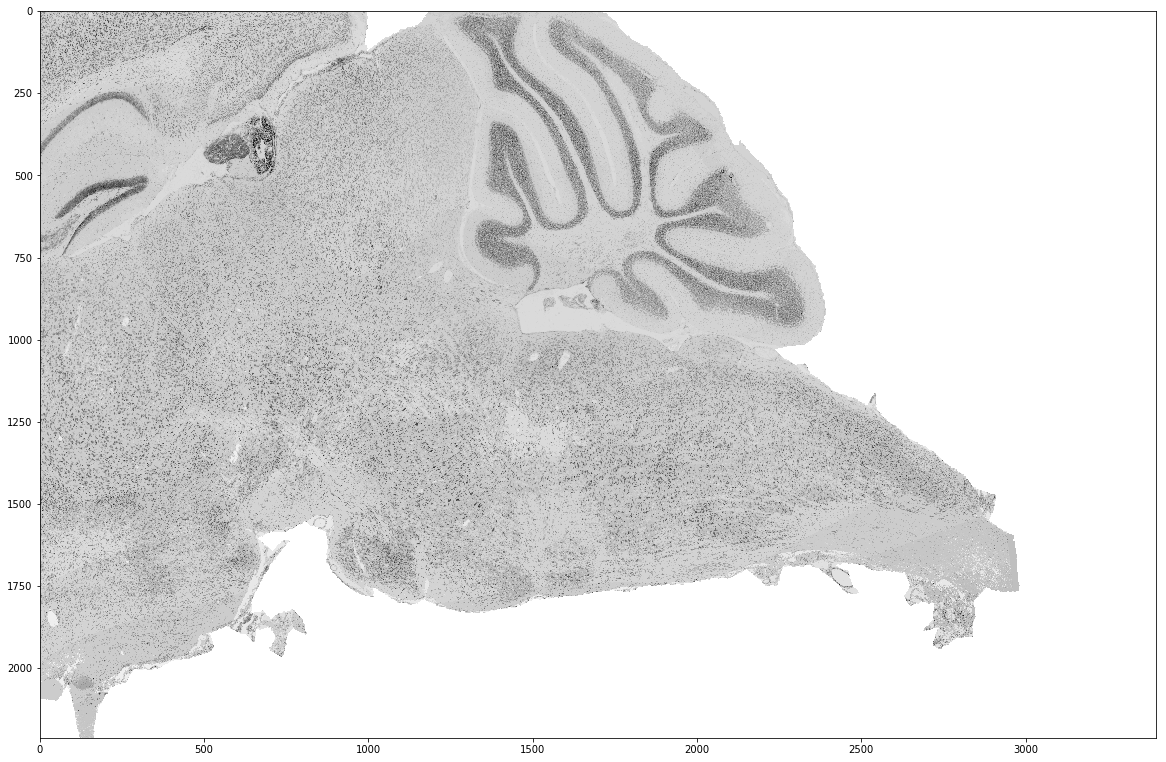

In [60]:
plt.figure(figsize=(20,20));
plt.imshow(img[::10, ::10], plt.cm.gray);

In [93]:
viz = DataManager.load_scoremap_viz_v2(stack='UCSD001', out_resolution='10.0um', 
                                       detector_id=799, prep_id=2, section=144, structure='12N')

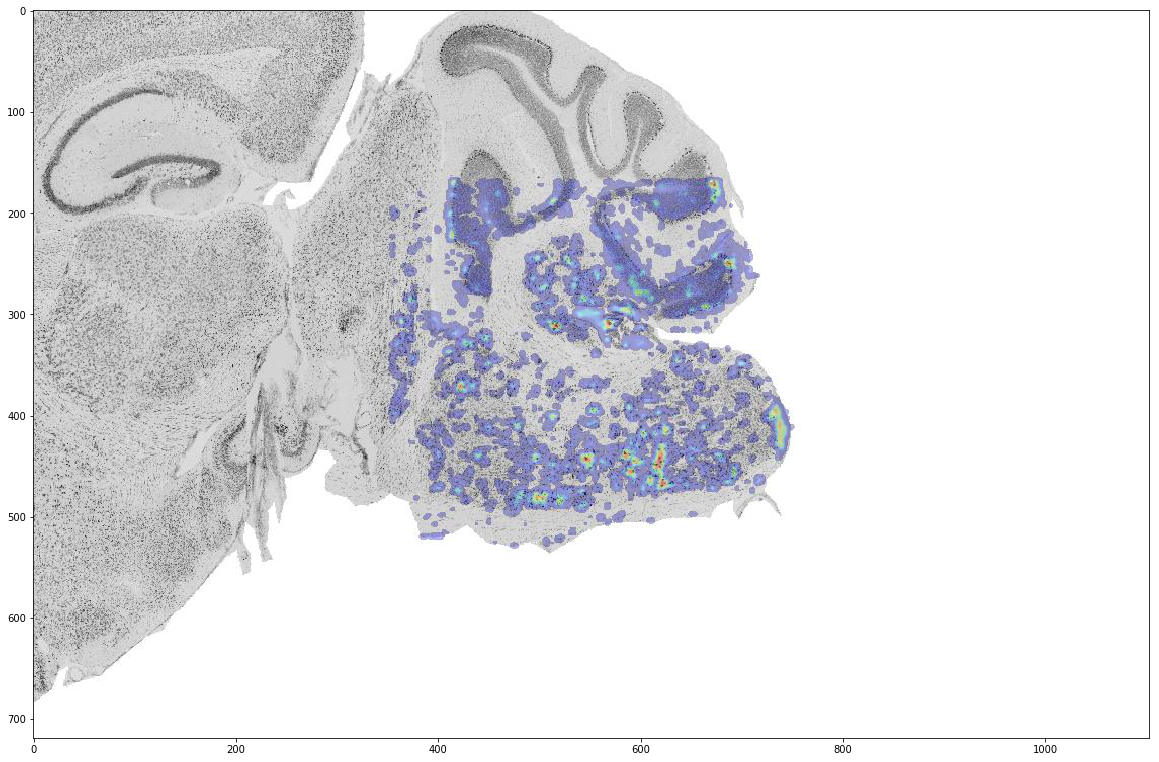

In [94]:
plt.figure(figsize=(20,20));
plt.imshow(viz);

In [98]:
viz = DataManager.load_scoremap_viz_v2(stack='UCSD001', out_resolution='10.0um', 
                                       detector_id=799, prep_id=2, section=144, structure='3N')

IOError: [Errno 2] No such file or directory: '/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_scoremap_viz/10.0um/3N/UCSD001/detector799/prep2/UCSD001_slide036_2018_09_03-S4_prep2_10.0um_3N_detector799_scoremapViz.jpg'

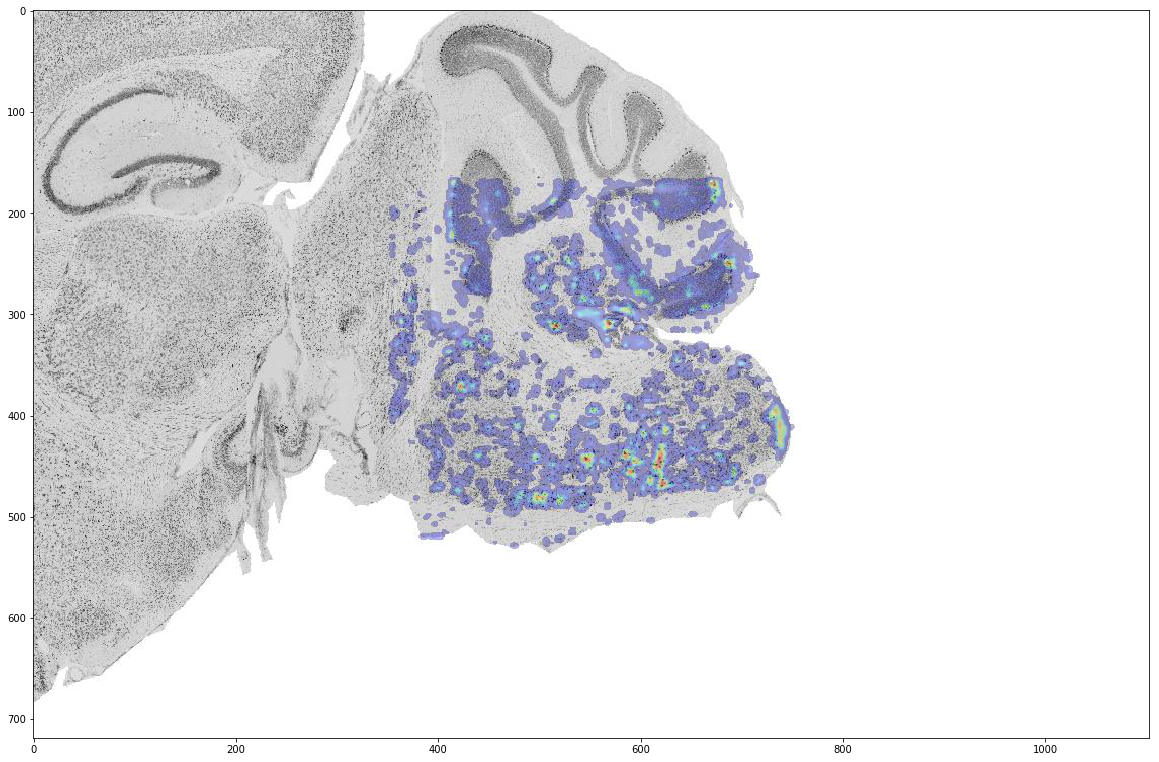

In [94]:
plt.figure(figsize=(20,20));
plt.imshow(viz);

In [ ]:
# IF SUCCESSFUL CONTINUE RUNNING SCRIPT_2